In [1]:
#
import numpy as np
import xarray as xr
from matplotlib.gridspec import GridSpec
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER 
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import os
import pandas as pd
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon, Point
import cmaps
import matplotlib.ticker as ticker
from PyEMD import EEMD
from scipy.fft import fft, fftfreq
from scipy.integrate import simpson
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.signal import butter, filtfilt
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress
import seawater
import warnings
import scipy
from scipy.ndimage import gaussian_filter
from scipy.stats import genextreme
from scipy.interpolate import RegularGridInterpolator
warnings.filterwarnings('ignore')

def add_right_cax_big (ax0, ax3, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax3. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x1 + pad, #ax0 的右边 (x1) 加上 pad 的值
        axpos2.y0,
        axpos1.x1 + pad + width,#颜色条的宽度
        axpos1.y1
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

def add_bottom_cax_big (ax0, ax3, pad, width) :#pad控制颜色条与 ax0 之间的间距
    axpos1=ax0. get_position ( )
    axpos2=ax3. get_position ( )
    caxpos = mpl.transforms.Bbox.from_extents( #Bbox.from_extents方法创建一个新的边界框
        axpos1.x0,
        axpos1.y0 - pad -width,
        axpos2.x1,
        axpos1.y0 - pad
    )
    cax=ax0.figure.add_axes(caxpos) #颜色条坐标轴
    return cax

plt.rcParams['font.sans-serif']=['Helvetica']

/tmp/ipykernel_43737/387287271.py:27: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater


In [2]:
fig_format = 'pdf'
mpl.rcParams['axes.unicode_minus'] = True

In [3]:
def is_point_inside_polygon(point, polygon):
    point_obj = Point(point[0], point[1])
    return polygon.contains(point_obj) #不规则图形掩码

def Area_mask(data,lat0,lat1,lon0,lon1,Points):
    mask = data.copy()
    try:
        mask.loc[{'lat':slice(lat0,lat1),'lon':slice(lon0,lon1)}] = np.nan
    except KeyError:
        mask.loc[{'latitude':slice(lat0,lat1),'longitude':slice(lon0,lon1)}] = np.nan
    
    polygon = Polygon(Points)

    it = np.ndindex(np.squeeze(data[0].T).shape)
    for idx in it:
        lon_idx = idx[0]
        lat_idx = idx[1]
        try:
            lon = mask.lon[lon_idx]
            lat = mask.lat[lat_idx]
        except AttributeError:
            lon = mask.longitude[lon_idx]
            lat = mask.latitude[lat_idx]
        point = (lon,lat)
        if is_point_inside_polygon(point, polygon):
            mask[:,lat_idx, lon_idx] = np.nan
    return mask

def weight_mean(data, dx, dy):
    weight = dx*dy
    res = np.full_like(data[:,0,0],np.nan)
    for i in range(np.shape(data)[0]):
        w = weight.copy()
        w[np.isnan(data[i])] = np.nan
        res[i] = np.nansum(data[i,:,:]*w,axis=(-2,-1))/np.nansum(w)
    return res

def weight_mean_4d(data, dx, dy):
    weight = dx*dy
    res = np.full_like(data[:,:,0,0],np.nan)
    for i in range(np.shape(data)[0]):
        for j in range(np.shape(data)[1]):
            w = weight.copy()
            w[np.isnan(data[i,j,:,:])] = np.nan
            res[i,j] = np.nansum(data[i,j,:,:]*w,axis=(-2,-1))/np.nansum(w)
    return res

def eemd(S,para = False):
    eemd = EEMD()
    eemd.parallel = para
    if para:
        eemd.processes = 5
    eemd.trails = 500
    eemd.noise_seed(1)
    eIMFs = eemd.eemd(S, np.arange(len(S)))
    period = []
    for i in range(np.shape(eIMFs)[0]):
        frequencies = fftfreq(len(eIMFs[i]), 1)
        fft_values = fft(eIMFs[i])
        positive_frequencies = frequencies[:len(eIMFs[i])//2]
        positive_fft_values = np.abs(fft_values[:len(eIMFs[i])//2])
        dominant_frequency = positive_frequencies[np.argmax(positive_fft_values)]
        period.append(1 / dominant_frequency)
    period = np.array(period)
    res0 = np.sum(eIMFs[period>20],0)
    res1 = gaussian_filter(S-np.sum(eIMFs,axis=0),3)
    res = res0 + res1
    return res

def linear_trend(data):
    slope = np.full_like(data[0],np.nan)
    p = np.full_like(data[0],np.nan)
    for i in range(np.shape(data)[1]):
        for j in range(np.shape(data)[2]):
            slope[i,j], _, _, p[i,j], _ = linregress(np.arange(len(data[:,i,j])),data[:,i,j])
    return slope, p

def return_level(T, shape, loc, scale):
    rp = np.zeros_like(T)
    for i in range(len(T)):
        p = 1 - 1/T[i]
        rp[i] = genextreme.ppf(p, shape, loc=loc, scale=scale)
    return rp

In [4]:
def Cal_mon_clim(data):
    data_bar = np.nanmean(np.reshape(np.array(data[120:480]),(30,12,np.shape(data)[1],np.shape(data)[2])),0)
    data_bar = np.tile(data_bar,(50,1,1))[:np.shape(data)[0]]
    data_prime = data - data_bar
    return data_bar, data_prime

def diag_period(data,t1,t2,mask,n):
    res = np.zeros(len(data))
    for i in range(len(data)):
        res[i] = annual_integral_1(weight_mean(data[i]*mask,dx,dy),t1,t2)[n]
    res = np.append(res,res[0]-np.sum(res[1:]))
    res = np.insert(res,1,np.sum(res[1:4]))
    res = np.insert(res,5,np.sum(res[5:8]))
    res = np.insert(res,9,np.sum(res[9:12]))
    return res

def convolve_ignore_nan(data, r, sig):
    # 获取数据的形状
    output = np.zeros_like(data)
    size = 2*r+1
    center = r
    # 创建一个空的二维数组
    kernel = np.fromiter(
        (np.exp(-((x - center)**2 + (y - center)**2) / (2 * sig**2)) 
         for x in range(size) for y in range(size)),
        dtype=float
    ).reshape((size, size))
    # 遍历每个位置
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            if ((i < r) | ((i+r)>=data.shape[0])):
                output[i,j] = data[i,j]
            else:
                if (j >= (data.shape[1] - r)):
                    region = np.append(data[i-r:i+r+1, j-r:],data[i-r:i+r+1, :r+1+j-data.shape[1]],1)
                elif (j < r):
                    region = np.append(data[i-r:i+r+1, -r+j:], data[i-r:i+r+1, :j+r+1],1)
                else:
                    region = data[i-r:i+r+1, j-r:j+r+1]
                
                # 只选择非 NaN 元素
                valid_values = region[~np.isnan(region)]
                valid_kernel = kernel[~np.isnan(region)]
                
                # 计算卷积，跳过 NaN
                if valid_values.size > 0:
                    output[i, j] = np.sum(valid_values * valid_kernel) / np.sum(valid_kernel)
    output[np.isnan(data)] = np.nan
    return output

def sel_year(data,m1,m2):
    res = np.zeros((int(len(data)/12),np.shape(data)[1],np.shape(data)[2]))
    for i in range(int(len(data)/12)):
        res[i] = np.mean(data[12*i+m1-1:12*i+m2],0)
    return res

def sel_year_1d(data,m1,m2):
    res = np.zeros(int(len(data)/12))
    for i in range(int(len(data)/12)):
        res[i] = np.mean(data[12*i+m1-1:12*i+m2])
    return res

def cal_transport_vert(lon,lat0,lat1):
    ind = (Lon==lon)&(Lat>lat0)&(Lat<lat1)
    sv = np.nansum(u_mld[:,ind]*dy[ind]*np.array(mld)[:,ind],axis=-1)
    return sv

def cal_transport_hor(lat,lon0,lon1):
    ind = (Lat==lat)&(Lon>lon0)&(Lon<lon1)
    sv = np.nansum(v_mld[:,ind]*dx[ind]*np.array(mld)[:,ind],axis=-1)
    return sv

In [5]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(S, cutoff, fs=1, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    res = filtfilt(b, a, S)
    return res

def tscale_filter(data):
    long = gaussian_filter(data,192/1.414) #32years
    multidecade = gaussian_filter(data-long,48/1.414) #8-32years
    interan = gaussian_filter(data-long-multidecade,12/1.414)  #2years
    return long, multidecade, interan

def sliding_corr(x, y, window_size):
    n = len(x)
    corr_values = np.empty(n - 2*window_size)
    p_values = np.empty(n - 2*window_size)
    for i in range(window_size, n - window_size):
        window_x = x[i - window_size : i + window_size+1]
        window_y = y[i - window_size : i + window_size+1]
        corr,p = pearsonr(window_x, window_y)
        corr_values[i-window_size] = corr
        p_values[i-window_size] = p
    return corr_values, p_values

In [6]:
def OISST_series():
    fpath = '/2024data2/yangsl/Yangsl/OISST/OISST/OISST_1982-2024.nc'  # 你的海平面温度数据文件路径
    sst = xr.open_dataset(fpath)['sst'].sel(lon=slice(104, 131.5),lat=slice(0,42)).squeeze()
    sst = sst.sel(time=~((sst.time.dt.month == 2) & (sst.time.dt.day == 29)))
    Points_E = [(131.5, 31.2),(130.5, 30.4),(129.5, 28.3),(129, 27.7),(128, 26.6),(125.3, 24.75),(123.75, 24.3),(123, 23.9),(131.5, 23.9)]
    Points_E1 = [(130.5, 34),(130.2, 35),(129.5, 35.5),(131.5, 35.5),(131.5, 34)]
    Points_S = [(120, 12),(119.5, 11),(118.5, 9.5),(117.5, 8.7),(117.2, 7.3),(117.2, 6),(121.5,6),(121.5,12)]
    sst_ES = Area_mask(sst,35.5,42,127,131.5,Points_E)
    sst_ES = Area_mask(sst_ES,0,6,117.2,122,Points_E1)
    sst_ES = Area_mask(sst_ES,0,24,121.5,131.5,Points_S)
    mask_ES = np.ones_like(sst_ES[0])
    mask_ES[np.isnan(sst_ES[0])] = np.nan
    return sst, mask_ES

def OSTIA_series():
    fpath = '/2024data2/yangsl/Yangsl/OSTIA/OSTIA.nc'  # 你的海平面温度数据文件路径
    sst = xr.open_dataset(fpath)['analysed_sst'].sel(longitude=slice(104, 131.5),latitude=slice(0,42)).squeeze()-273.15
    sst = sst.sel(time=~((sst.time.dt.month == 2) & (sst.time.dt.day == 29)))
    Points_E = [(131.5, 31.2),(130.5, 30.4),(129.5, 28.3),(129, 27.7),(128, 26.6),(125.3, 24.75),(123.75, 24.3),(123, 23.9),(131.5, 23.9)]
    Points_E1 = [(130.5, 34),(130.2, 35),(129.5, 35.5),(131.5, 35.5),(131.5, 34)]
    Points_S = [(120, 12),(119.5, 11),(118.5, 9.5),(117.5, 8.7),(117.2, 7.3),(117.2, 6),(121.5,6),(121.5,12)]
    sst_ES = Area_mask(sst,35.5,42,127,131.5,Points_E)
    sst_ES = Area_mask(sst_ES,0,6,117.2,122,Points_E1)
    sst_ES = Area_mask(sst_ES,0,24,121.5,131.5,Points_S)
    mask_ES = np.ones_like(sst_ES[0])
    mask_ES[np.isnan(sst_ES[0])] = np.nan
    return sst, mask_ES

def Had_series():
    fpath = '/2024data2/yangsl/Yangsl/HadISST/HadISST_sst.nc'  # 你的海平面温度数据文件路径
    sst = xr.open_dataset(fpath)['sst']
    sst = sst.reindex(latitude=list(reversed(sst.latitude))).sel(longitude=slice(104, 131.5),latitude=slice(0,42)).squeeze()
    Points_E = [(131.5, 31.2),(130.5, 30.4),(129.5, 28.3),(129, 27.7),(128, 26.6),(125.3, 24.75),(123.75, 24.3),(123, 23.9),(131.5, 23.9)]
    Points_E1 = [(130.5, 34),(130.2, 35),(129.5, 35.5),(131.5, 35.5),(131.5, 34)]
    Points_S = [(120, 12),(119.5, 11),(118.5, 9.5),(117.5, 8.7),(117.2, 7.3),(117.2, 6),(121.5,6),(121.5,12)]
    sst_ES = Area_mask(sst,35.5,42,127,131.5,Points_E)
    sst_ES = Area_mask(sst_ES,0,6,117.2,122,Points_E1)
    sst_ES = Area_mask(sst_ES,0,24,121.5,131.5,Points_S)
    mask_ES = np.ones_like(sst_ES[0])
    mask_ES[np.isnan(sst_ES[0])] = np.nan
    return sst, mask_ES

In [7]:
def plot_land_3d(lon0,lon1,lat0,lat1,z0,res='110m',lw=0.5):
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import cartopy.feature as cf
    from cartopy.mpl.patch import geos_to_path

    proj_ax = plt.figure().add_subplot(111, projection=ccrs.PlateCarree())
    proj_ax.set_xlim(lon0,lon1)
    proj_ax.set_ylim(lat0,lat1)
    feature = cf.NaturalEarthFeature('physical', 'land', res)
    geoms = feature.geometries()
    boundary = proj_ax._get_extent_geom()
    # 投影并裁剪
    proj = proj_ax.projection
    geoms = [proj.project_geometry(g, feature.crs) for g in geoms if g.is_valid]
    polys2d = []
    for g in geoms:
        inter = boundary.intersection(g)
        for path in geos_to_path(inter):
            for poly in path.to_polygons():
                polys2d.append(poly)

    plt.close(proj_ax.figure)  # 不要显示临时小图
    verts3d = []
    for poly in polys2d:
        verts3d.append([(x, y, z0) for x,y in poly])

    pc3d = Poly3DCollection(verts3d,
                            facecolor='white',
                            edgecolor='black',
                            linewidths=lw,
                            alpha=0.0)
    return pc3d

In [8]:
# 温度提取
sst_ES_oisst, mask_ES_oisst = OISST_series()
sst_ES_ostia, mask_ES_ostia = OSTIA_series()
sst_ES_hadl, mask_ES_hadl = Had_series()
# ssh = xr.open_dataset('./ORAS5/ssh_202408.nc')['SSH'].sel(lon=slice(104, 131.5),lat=slice(0,42)).squeeze().interp(lon=sst_ES_oisst.lon,lat=sst_ES_oisst.lat)

In [10]:
# 时间和经纬度
date = pd.date_range('2023-01-01', '2023-12-31', freq='D')
date_year_oisst = pd.date_range('1982-01-01', '2024-12-31', freq='YE')
date_month_oisst = pd.date_range('1982-01-01', '2024-12-31', freq='ME')
date_hadl = pd.date_range('2023-01-31', '2023-12-31', freq='ME') - pd.Timedelta(days=15)
Lon, Lat = np.meshgrid(sst_ES_oisst.lon, sst_ES_oisst.lat)
dx = 6371*1e3*np.pi/180*np.gradient(Lon,axis=1)*np.cos(np.radians(Lat))
dy = 6371*1e3*np.pi/180*np.gradient(Lat,axis=0)
Lon_hadl, Lat_hadl = np.meshgrid(sst_ES_hadl.longitude, sst_ES_hadl.latitude)
dx_hadl = 6371*1e3*np.pi/180*np.gradient(Lon_hadl,axis=1)*np.cos(np.radians(Lat_hadl))
dy_hadl = 6371*1e3*np.pi/180*np.gradient(Lat_hadl,axis=0)
Lon_ostia, Lat_ostia = np.meshgrid(sst_ES_ostia.longitude, sst_ES_ostia.latitude)
dx_ostia = 6371*1e3*np.pi/180*np.gradient(Lon_ostia,axis=1)*np.cos(np.radians(Lat_ostia))
dy_ostia = 6371*1e3*np.pi/180*np.gradient(Lat_ostia,axis=0)

In [11]:
mask_E_oisst = mask_ES_oisst.copy()
mask_E_oisst[Lat<23] = np.nan
mask_E_hadl = mask_ES_hadl.copy()
mask_E_hadl[Lat_hadl<23] = np.nan
mask_E_ostia = mask_ES_ostia.copy()
mask_E_ostia[Lat_ostia<23] = np.nan

In [12]:
# 中国近海全部海域平均温度
sst_all = weight_mean(sst_ES_oisst*mask_E_oisst,dx,dy)
base_all = np.mean(np.reshape(sst_all[9*365:39*365],(30,365)),0)
std_all = np.std(np.reshape(sst_all[9*365:39*365],(30,365)),0,ddof=1)

sst_all_hadl = weight_mean(sst_ES_hadl*mask_E_hadl,dx_hadl,dy_hadl)
base_all_hadl = np.mean(np.reshape(sst_all_hadl[121*12:151*12],(30,12)),0)
std_all_hadl = np.std(np.reshape(sst_all_hadl[121*12:151*12],(30,12)),0,ddof=1)
dp90_all_hadl = np.percentile(np.reshape(sst_all_hadl[121*12:151*12],(30,12)),90,axis=0) - base_all_hadl

sst_all_ostia = weight_mean(sst_ES_ostia*mask_E_ostia,dx_ostia,dy_ostia)

In [13]:
# 获取8-9月数据和高温掩膜
sst_ES_oisst_89 = sst_ES_oisst.sel(time=((sst_ES_oisst["time.month"] == 8) | (sst_ES_oisst["time.month"] == 9)))
base_ES_89 = np.mean(sst_ES_oisst_89.sel(time=((sst_ES_oisst_89["time.year"] < 2021) & (sst_ES_oisst_89["time.year"] > 1990))),0)
std_ES_89 = np.std(sst_ES_oisst_89.sel(time=((sst_ES_oisst_89["time.year"] < 2021) & (sst_ES_oisst_89["time.year"] > 1990))).groupby("time.year").mean(dim="time"),0)
year_ES_89 = sst_ES_oisst_89.resample(time='YE').mean()

mask_max = np.full_like(year_ES_89[0],np.nan)
mask_max[np.where(np.max(year_ES_89[:-1],0) <= year_ES_89[-1])] = 1
mask_hightemp = np.full_like(year_ES_89[0],np.nan)
mask_hightemp[(np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89)/std_ES_89>3] = 1
mask_hightemp[np.isnan(mask_ES_oisst)] = np.nan

sst_high = weight_mean(sst_ES_oisst*mask_hightemp,dx,dy)
base_high = np.mean(np.reshape(sst_high[9*365:39*365],(30,365)),0)
std_high = np.std(np.reshape(sst_high[9*365:39*365],(30,365)),0)
P90_high = np.percentile(np.reshape(sst_high[9*365:39*365],(30,365)),90,axis=0)
year_high_89 = weight_mean(year_ES_89*mask_hightemp,dx,dy)
year_ES = sst_ES_oisst.resample(time='YE').mean()
year_high = weight_mean(year_ES*mask_hightemp,dx,dy)

# 其他掩膜
mask_YS = np.full_like(mask_hightemp,np.nan)
mask_YS[((0.3*Lon-Lat)<4.5)&(Lon<127)] =1
mask_YS[np.isnan(mask_hightemp)] = np.nan

mask_ECS = np.full_like(mask_hightemp,np.nan)
mask_ECS[~np.isnan(mask_hightemp)&np.isnan(mask_YS)] = 1

mask_land = np.full_like(mask_hightemp,np.nan)
mask_land[np.isnan(sst_ES_oisst[0])] = 1

sst_high_YS = weight_mean(sst_ES_oisst*mask_YS,dx,dy)
base_high_YS = np.mean(np.reshape(sst_high_YS[9*365:39*365],(30,365)),0)
std_high_YS = np.std(np.reshape(sst_high_YS[9*365:39*365],(30,365)),0)

sst_high_ECS = weight_mean(sst_ES_oisst*mask_ECS,dx,dy)
base_high_ECS = np.mean(np.reshape(sst_high_ECS[9*365:39*365],(30,365)),0)
std_high_ECS = np.std(np.reshape(sst_high_ECS[9*365:39*365],(30,365)),0)

In [14]:
# 中国近海全部海域平均温度
# sst_all = weight_mean(sst_ES_oisst*mask_hightemp,dx,dy)
# base_all = np.mean(np.reshape(sst_all[9*365:39*365],(30,365)),0)
# std_all = np.std(np.reshape(sst_all[9*365:39*365],(30,365)),0,ddof=1)
interp = RegularGridInterpolator(
        (sst_ES_oisst.lat.data, sst_ES_oisst.lon.data), 
        mask_hightemp,
        method='linear',
        bounds_error=False,
        fill_value=np.nan
    )

mask_hightemp_hadl = interp(np.column_stack([Lat_hadl.ravel(), Lon_hadl.ravel()])).reshape(Lat_hadl.shape)
mask_hightemp_ostia = interp(np.column_stack([Lat_ostia.ravel(), Lon_ostia.ravel()])).reshape(Lat_ostia.shape)

sst_high_hadl = weight_mean(sst_ES_hadl*mask_hightemp_hadl,dx_hadl,dy_hadl)
base_high_hadl = np.mean(np.reshape(sst_high_hadl[121*12:151*12],(30,12)),0)
std_high_hadl = np.std(np.reshape(sst_high_hadl[121*12:151*12],(30,12)),0,ddof=1)
dp90_high_hadl = np.percentile(np.reshape(sst_high_hadl[121*12:151*12],(30,12)),90,axis=0) - base_high_hadl

sst_high_ostia = weight_mean(sst_ES_ostia*mask_hightemp_ostia,dx_ostia,dy_ostia)

In [ ]:
# 尺度分离
_, sst_month_oisst = Cal_mon_clim(sst_ES_oisst.resample(time='1M').mean())
t_long_high,t_multidecad_high,t_intan_high = tscale_filter(weight_mean(sst_month_oisst*mask_hightemp,dx,dy))

In [15]:
# return period
std_sst_high = (sst_high-np.tile(base_high,43))/np.tile(std_high,43)
dates = pd.date_range(start='1982-01-01', end='2024-12-31', freq='D')

dates = dates[~((dates.month == 2) & (dates.day == 29))]
years = dates
df = xr.DataArray(std_sst_high,coords={"time":dates}).resample(time='ME').mean(dim='time')
std_sst_high_now = np.array(df)[-12:]
std_sst_high_ex = np.array(df.groupby('time.year').max())[:-1]

sorted_ex_his = np.sort(std_sst_high_ex)[::-1]
return_periods_his = (len(std_sst_high_ex) + 1) / np.arange(1, len(std_sst_high_ex)+1)

shape, loc, scale = genextreme.fit(std_sst_high_ex)
RP = np.concatenate([np.linspace(1.00001,9.9,89),np.linspace(10,99,90),np.linspace(100,500,200),
                     np.linspace(520,1000,100),np.linspace(1010,10000,100),np.linspace(100100,100000,100)])
RV = return_level(RP, shape, loc, scale)

n_bootstrap = 500
bootstrap_levels = np.zeros((n_bootstrap, len(RP)))
for i in range(n_bootstrap):
    if (i%100==0):
        print(i)
    sample = np.random.choice(std_sst_high_ex, size=len(std_sst_high_ex), replace=True)
    shape_b, loc_b, scale_b = genextreme.fit(sample)
    bootstrap_levels[i, :] = return_level(RP, shape_b, loc_b, scale_b)

ci_lower = np.percentile(bootstrap_levels, 2.5, axis=0)
ci_upper = np.percentile(bootstrap_levels, 97.5, axis=0)

#
std_sst_high_ex1 = np.array(df.groupby('time.year').max())
sorted_ex_his1 = np.sort(std_sst_high_ex1)[::-1]
return_periods_his1 = (len(std_sst_high_ex1) + 1) / np.arange(1, len(std_sst_high_ex1)+1)

shape1, loc1, scale1 = genextreme.fit(std_sst_high_ex1)
# RP = np.concatenate([np.linspace(1.00001,9.9,89),np.linspace(10,99,90),np.linspace(100,500,200),
#                      np.linspace(520,1000,100),np.linspace(1010,10000,100),np.linspace(100100,100000,100)])
RV1 = return_level(RP, shape1, loc1, scale1)

bootstrap_levels1 = np.zeros((n_bootstrap, len(RP)))
for i in range(n_bootstrap):
    if (i%100==0):
        print(i)
    sample1 = np.random.choice(std_sst_high_ex1, size=len(std_sst_high_ex1), replace=True)
    shape_b1, loc_b1, scale_b1 = genextreme.fit(sample1)
    bootstrap_levels1[i, :] = return_level(RP, shape_b1, loc_b1, scale_b1)

ci_lower1 = np.percentile(bootstrap_levels1, 2.5, axis=0)
ci_upper1 = np.percentile(bootstrap_levels1, 97.5, axis=0)

0
100
200
300
400
0
100
200
300
400


In [16]:
# return period
std_sst_high_hadl= (sst_high_hadl[:-1]-np.tile(base_high_hadl,155))/np.tile(std_high_hadl,155)
dates_hadl = pd.date_range(start='1870-01-01', end='2024-12-31', freq='M')

# years = dates
df_hadl = xr.DataArray(std_sst_high_hadl,coords={"time":dates_hadl})
std_sst_high_hadl_now = np.array(df_hadl)[-12:]
std_sst_high_hadl_ex = np.array(df_hadl.groupby('time.year').max())[:-1]

sorted_ex_his_hadl = np.sort(std_sst_high_hadl_ex)[::-1]
return_periods_his_hadl = (len(std_sst_high_hadl_ex) + 1) / np.arange(1, len(std_sst_high_hadl_ex)+1)

shape_hadl, loc_hadl, scale_hadl = genextreme.fit(std_sst_high_hadl_ex)
RV_hadl = return_level(RP, shape_hadl, loc_hadl, scale_hadl)
bootstrap_levels_hadl = np.zeros((n_bootstrap, len(RP)))
for i in range(n_bootstrap):
    if (i%100==0):
        print(i)
    sample_hadl = np.random.choice(std_sst_high_hadl_ex, size=len(std_sst_high_hadl_ex), replace=True)
    shape_b_hadl, loc_b_hadl, scale_b_hadl = genextreme.fit(sample_hadl)
    bootstrap_levels_hadl[i, :] = return_level(RP, shape_b_hadl, loc_b_hadl, scale_b_hadl)

ci_lower_hadl = np.percentile(bootstrap_levels_hadl, 2.5, axis=0)
ci_upper_hadl = np.percentile(bootstrap_levels_hadl, 97.5, axis=0)


std_sst_high_hadl_ex1 = np.array(df_hadl.groupby('time.year').max())
sorted_ex_his1_hadl = np.sort(std_sst_high_hadl_ex1)[::-1]
return_periods_his1_hadl = (len(std_sst_high_hadl_ex1) + 1) / np.arange(1, len(std_sst_high_hadl_ex1)+1)

shape1_hadl, loc1_hadl, scale1_hadl = genextreme.fit(std_sst_high_hadl_ex1)
# RP = np.concatenate([np.linspace(1.00001,9.9,89),np.linspace(10,99,90),np.linspace(100,500,200),
#                      np.linspace(520,1000,100),np.linspace(1010,10000,100),np.linspace(100100,100000,100)])
RV1_hadl = return_level(RP, shape1_hadl, loc1_hadl, scale1_hadl)

bootstrap_levels1_hadl = np.zeros((n_bootstrap, len(RP)))
for i in range(n_bootstrap):
    if (i%100==0):
        print(i)
    sample1_hadl = np.random.choice(std_sst_high_hadl_ex1, size=len(std_sst_high_hadl_ex1), replace=True)
    shape_b1_hadl, loc_b1_hadl, scale_b1_hadl = genextreme.fit(sample1_hadl)
    bootstrap_levels1_hadl[i, :] = return_level(RP, shape_b1_hadl, loc_b1_hadl, scale_b1_hadl)

ci_lower1_hadl = np.percentile(bootstrap_levels1_hadl, 2.5, axis=0)
ci_upper1_hadl = np.percentile(bootstrap_levels1_hadl, 97.5, axis=0)

0
100
200
300
400
0
100
200
300
400


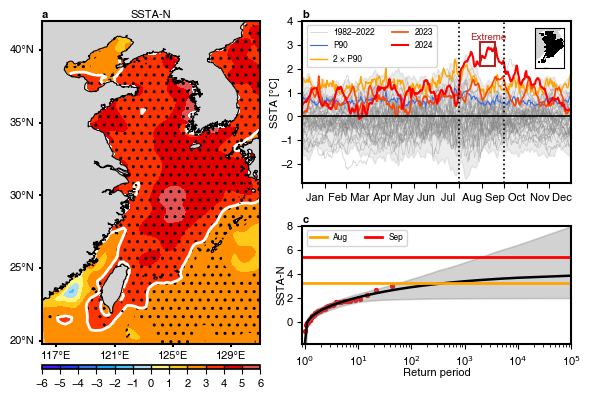

In [91]:
fig = plt.figure(figsize=(7, 4.2))
fig.subplots_adjust(hspace=0.3,wspace=0)
gs = GridSpec(2, 3, figure=fig,width_ratios=[1.0,0.12,1.1],height_ratios=[1.1,0.8])

ax1 = fig.add_subplot(gs[1, 2])
ax1.scatter(return_periods_his, sorted_ex_his, s=8,c='r')
ax1.plot(RP, RV, lw=1.8,c='k')
ax1.fill_between(RP, ci_lower,ci_upper, lw=1.2,color='grey',alpha=0.35)
ax1.plot([0.1,1e6],[std_sst_high_now[7],std_sst_high_now[7]],'orange',lw=2,label='Aug')
ax1.plot([0.1,1e6],[std_sst_high_now[8],std_sst_high_now[8]],'r',lw=2,label='Sep')
# ax1.plot([0.1,1e6],[std_sst_high_now[9],std_sst_high_now[9]],'purple',lw=2,label='Oct')
ax1.set_xscale('log')
ax1.set_xlim([0.9,1e5])
ax1.set_ylim([-1.8,8])
ax1.set_xticks([1,10,1e2,1e3,1e4,1e5],['10$^0$','10$^1$','10$^2$','10$^3$','10$^4$','10$^5$'],fontsize=8)
ax1.set_yticks([0,2,4,6,8],[0,2,4,6,8],fontsize=8)
ax1.set_xlabel('Return period',fontsize=8,labelpad=0)
ax1.set_ylabel('SSTA-N',fontsize=8,labelpad=0)
ax1.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=3,fontsize=6)
ax1.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax2 = fig.add_subplot(gs[:2, 0], projection=ccrs.PlateCarree())
ax2.set_extent([116,131,19.8,42])
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=0.8,zorder=4)
cs = ax2.contourf(sst_ES_oisst.lon, sst_ES_oisst.lat,(np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89)/std_ES_89,
                  levels=np.linspace(-6,6,13),cmap = cmaps.ncl_default,transform=ccrs.PlateCarree())
contour_lines = ax2.contour(
    sst_ES_oisst.lon, sst_ES_oisst.lat, (np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89)/std_ES_89, levels=[3],
    colors='w', linewidths=2, transform=ccrs.PlateCarree())
# ax2.contour(
#     ssh.lon, ssh.lat, ssh, levels=[0.92],
#     colors='purple', linewidths=8, transform=ccrs.PlateCarree())
# ax2.contour(
#     sst_ES_oisst.lon, sst_ES_oisst.lat, np.isnan(mask_ES_oisst), levels=[0.5,1.5],
#     colors='k', linestyles='-.',linewidths=2, transform=ccrs.PlateCarree())
ax2.contourf(
    sst_ES_oisst.lon, sst_ES_oisst.lat, mask_max,
    colors='none',hatches=['..'], transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder=2)
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([117, 121, 125, 129])
ax2.set_xticklabels([' ',' ',' ',' '])
ax2.set_yticks([20, 25, 30, 35, 40])
ax2.set_yticklabels([' ',' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl2.ylocator = ticker.FixedLocator([20, 25, 30, 35, 40])
ax2.tick_params(axis='both', length=2, width=1.5)
ax2.spines['geo'].set_linewidth(1.5)
cax = add_bottom_cax_big(ax2,ax2, pad=0.05, width=0.01)
cb =  fig.colorbar(cs,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
cb.set_ticklabels(['−6','−5','−4','−3','−2','−1','0','1','2','3','4','5','6'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)

ax3 = fig.add_subplot(gs[0, 2])
for i in range(41):
    if i == 40:
        ax3.plot(date,(sst_high[365*i:365*(i+1)]-base_high),'grey',lw=0.5,alpha=0.4,label='1982\u20132022')
    else:
        ax3.plot(date,(sst_high[365*i:365*(i+1)]-base_high),'grey',lw=0.5,alpha=0.4)
# ax3.fill_between(date,-std_high,std_high,color='grey',alpha=0.3)
# ax3.fill_between(date,-2*std_high,2*std_high,color='grey',alpha=0.2)
ax3.fill_between(date,-3*std_high,3*std_high,color='grey',alpha=0.15)
ax3.plot(date,(P90_high-base_high),'royalblue',lw=0.8,label='P90')
ax3.plot(date,2*(P90_high-base_high),'orange',lw=1,label='2 × P90')
# ax3.plot(date[4*(P90_high-base_high)<(sst_high[365*42:]-base_high)],4*(P90_high-base_high)[4*(P90_high-base_high)<(sst_high[365*42:]-base_high)],'r',lw=1.5)
# ax3.fill_between(date[241:262],4*(P90_high-base_high)[241:262],
#         (sst_high[365*42:]-base_high)[241:262],color='firebrick',alpha=1)
ax3.plot(date,sst_high[365*41:365*42]-base_high,'orangered',lw=1.2,label='2023')
ax3.plot(date,sst_high[365*42:]-base_high,'r',lw=1.5,label='2024')
ax3.plot(date,np.zeros(365),'k',lw=1.2)
ax3.plot([date[212],date[212]],[-5,5],'k',lw=1.2,ls=':')
ax3.plot([date[273],date[273]],[-5,5],'k',lw=1.2,ls=':')
ax3.set_xlim([date[0],date[-1]])
ax3.set_ylim([-2.8,4])
ax3.set_xticks(date[[0,31,59,90,120,151,181,212,243,273,304,334]],['        Jan','        Feb','         Mar','        Apr','        May','        Jun',
                                                                   '        Jul','        Aug','        Sep','        Oct','        Nov','        Dec'],fontsize=8)
ax3.set_yticks([-2,-1,0,1,2,3,4],['−2','−1','0','1','2','3','4'],fontsize=8)
# ax3.set_xlabel('Month',fontsize=8)
ax3.set_ylabel('SSTA [°C]',fontsize=8,labelpad=0)
ax3.text(date[227],3.2,'Extreme',color='firebrick',fontsize=7)
rect1 = patches.Rectangle((date[241], 2.1),
                             date[261]-date[241], 1,
                             edgecolor='firebrick', facecolor='None', linewidth=1.5,zorder=2)
ax3.add_patch(rect1)
# ax3.plot([date[241],date[241]],[2.1,3.1], color='firebrick', lw=1.5)
# ax3.plot([date[261],date[261]],[2.1,3.1], color='firebrick', lw=1.5)
ax3.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=2,fontsize=6)
ax3.spines[['top','bottom','left','right']].set_linewidth(1.5)
inset_ax = inset_axes(ax3, width="11%", height="25%", loc="upper right")
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_hightemp[70:,45:],colors='k')
inset_ax.set_xticks([])
inset_ax.set_yticks([])

# ax0.set_title('(a)',fontsize=15,loc='left')
ax1.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('SSTA-N',fontsize=8,pad=2)
ax3.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
# ax4.set_title('(e)',fontsize=15,loc='left')
fig.savefig('./fig/Fig1.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

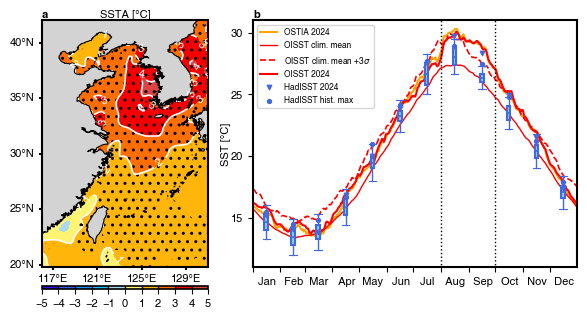

In [92]:
fig = plt.figure(figsize=(7, 3.2))
fig.subplots_adjust(wspace=0.15)
gs = GridSpec(1, 2, figure=fig,width_ratios=[1,1.8])

ax0 = fig.add_subplot(gs[0, 1])
# ax0.plot(np.arange(1,366,1),(sst_all_ostia[365*16:365*17]),'orange',lw=0.8,alpha=1) #2023
ax0.plot(np.arange(1,366,1),sst_high_ostia[-365:],'orange',lw=1.5,label='OSTIA 2024')
# ax0.plot(np.arange(1,366,1),(sst_high_ostia[365*9:365*10]),'orange',lw=1,ls=':',alpha=1,label='OSTIA 2016') # 2016
# ax0.plot(np.arange(1,366,1),(sst_high_ostia[365*16:365*17]),'orange',lw=1,ls='--',alpha=1,label='OSTIA 2023') # 2022
# ax0.plot(np.arange(1,366,1),sst_high_ostia[-365:],'orange',lw=2,label='OSTIA 2024')

ax0.plot(np.arange(1,366,1),base_high,color='r',lw=1,label='OISST clim. mean')
ax0.plot(np.arange(1,366,1),3*std_high+base_high,color='r',ls='--',lw=1.2,label='OISST clim. mean +3$\sigma$')
ax0.plot(np.arange(1,366,1),sst_high[365*42:],'r',lw=1.5,label='OISST 2024')

box_width = 4
box_t = 15+np.array([1,31,59,90,120,151,181,212,243,273,304,334])

for i in range(12):
    rect = patches.Rectangle((box_t[i] - box_width/2, base_high_hadl[i] - dp90_high_hadl[i]),
                             box_width, 2*dp90_high_hadl[i],
                             edgecolor='royalblue', facecolor='skyblue', linewidth=1.5,zorder=2)
    ax0.add_patch(rect)
    ax0.plot([box_t[i] - box_width/3, box_t[i] + box_width/3],
            [base_high_hadl[i] , base_high_hadl[i]],
            color='royalblue', linewidth=1.2,zorder=2)
    ax0.plot([box_t[i] - box_width, box_t[i] + box_width],
            [base_high_hadl[i] + 3*std_high_hadl[i], base_high_hadl[i] + 3*std_high_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=0.8,zorder=2)
    ax0.plot([box_t[i] - box_width, box_t[i] + box_width],
            [base_high_hadl[i] - 3*std_high_hadl[i], base_high_hadl[i] - 3*std_high_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=0.8,zorder=2)

    ax0.plot([box_t[i], box_t[i]], [base_high_hadl[i] + dp90_high_hadl[i], base_high_hadl[i] + 3*std_high_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=1,zorder=2)
    ax0.plot([box_t[i], box_t[i]], [base_high_hadl[i] - dp90_high_hadl[i], base_high_hadl[i] - 3*std_high_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=1,zorder=2)

ax0.scatter(box_t,sst_high_hadl[-13:-1], s=10, marker='v', color='royalblue',zorder=2,label='HadISST 2024')
ax0.scatter(box_t,np.max(np.reshape(sst_high_hadl[:-13],(154,12)),0), s=8, marker='o', color='royalblue',zorder=2,label='HadISST hist. max')

# ax0.plot(np.arange(1,366,1),base_high,color='r',lw=1.2,label='OISST Climatological Mean')
# ax0.plot(np.arange(1,366,1),3*std_high+base_high,color='r',ls='--',lw=1.5,label='OISST Climatological Mean +3$\sigma$')
# ax0.plot(np.arange(1,366,1),sst_high[365*42:],'r',lw=2,label='OISST 2024')

ax0.plot([212.5,212.5],[0,40],'k',lw=1,ls=':')
ax0.plot([273,273],[0,40],'k',lw=1,ls=':')
ax0.set_xlim([1,365])
ax0.set_ylim([11,31])
ax0.set_xticks([1,31,59,90,120,151,181,212,243,273,304,334],['         Jan','         Feb','         Mar','         Apr','         May','         Jun',
                                                                   '         Jul','         Aug','         Sep','         Oct','         Nov','         Dec'],fontsize=8)
ax0.set_yticks([15,20,25,30],[15,20,25,30],fontsize=8)
# ax0.set_xlabel('Month',fontsize=8)
ax0.set_ylabel('SST [°C]',fontsize=8,labelpad=0)
ax0.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=6)
ax0.spines[['top','bottom','left','right']].set_linewidth(1.5)
# inset_ax = inset_axes(ax0, width="12%", height="22%", loc="upper right")
# inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
# inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_hightemp[70:,45:],colors='k')
# inset_ax.set_xticks([])
# inset_ax.set_yticks([])

ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2.set_extent([116,131,19.8,42])
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=0.8,zorder=4)
cs = ax2.contourf(sst_ES_oisst.lon, sst_ES_oisst.lat,(np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89),
                  levels=np.linspace(-5,5,11),cmap = cmaps.ncl_default,transform=ccrs.PlateCarree())
cc = ax2.contour(sst_ES_oisst.lon, sst_ES_oisst.lat,(np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89),
                  levels=[1,2,3,4], colors='w', linewidths=1.2,transform=ccrs.PlateCarree())
ax2.clabel(cc,fontsize=8)
ax2.contourf(
    sst_ES_oisst.lon, sst_ES_oisst.lat, mask_max,
    colors='none',hatches=['..'], transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder=2)
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([117, 121, 125, 129])
ax2.set_xticklabels([' ',' ',' ',' '])
ax2.set_yticks([20, 25, 30, 35, 40])
ax2.set_yticklabels([' ',' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([117, 121,125, 129])
gl2.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax2.tick_params(axis='both', length=2, width=1.5)
ax2.spines['geo'].set_linewidth(1.5)

cax = add_bottom_cax_big(ax2,ax2, pad=0.06, width=0.01)
cb =  fig.colorbar(cs,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-5,-4,-3,-2,-1,0,1,2,3,4,5])
cb.set_ticklabels(['−5','−4','−3','−2','−1','0','1','2','3','4','5'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)

ax0.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('SSTA [°C]',fontsize=8,pad=2)

fig.savefig('./fig/FigS1.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

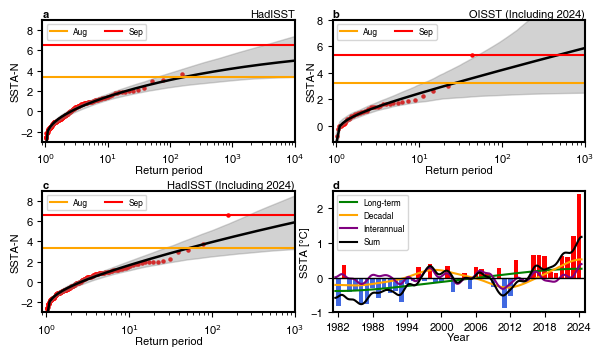

In [93]:
fig = plt.figure(figsize=(7, 3.8))
fig.subplots_adjust(hspace=0.4,wspace=0.15)
gs = GridSpec(2, 2, figure=fig,width_ratios=[1.0,1.0],height_ratios=[1.1,1.1])

ax0 = fig.add_subplot(gs[0, 0])
ax0.scatter(return_periods_his_hadl, sorted_ex_his_hadl, s=5,c='r')
ax0.plot(RP, RV_hadl, lw=1.8,c='k')
ax0.fill_between(RP, ci_lower_hadl,ci_upper_hadl, lw=1,color='grey',alpha=0.35)
ax0.plot([0.1,1e6],[std_sst_high_hadl_now[7],std_sst_high_hadl_now[7]],'orange',lw=1.5,label='Aug')
ax0.plot([0.1,1e6],[std_sst_high_hadl_now[8],std_sst_high_hadl_now[8]],'r',lw=1.5,label='Sep')
# ax1.plot([0.1,1e6],[std_sst_high_now[9],std_sst_high_now[9]],'purple',lw=2,label='Oct')
ax0.set_xscale('log')
ax0.set_xlim([0.9,1e4])
ax0.set_ylim([-3,9])
ax0.set_xticks([1,10,1e2,1e3,1e4],['10$^0$','10$^1$','10$^2$','10$^3$','10$^4$'],fontsize=8)
ax0.set_yticks([-2,0,2,4,6,8],['−2','0','2','4','6','8'],fontsize=8)
ax0.set_xlabel('Return period',fontsize=8,labelpad=0)
ax0.set_ylabel('SSTA-N',fontsize=8,labelpad=0)
ax0.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=3,fontsize=6)
ax0.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax1 = fig.add_subplot(gs[0, 1])
ax1.scatter(return_periods_his1, sorted_ex_his1, s=5,c='r')
ax1.plot(RP, RV1, lw=1.8,c='k')
ax1.fill_between(RP, ci_lower1,ci_upper1, lw=1,color='grey',alpha=0.35)
ax1.plot([0.1,1e6],[std_sst_high_now[7],std_sst_high_now[7]],'orange',lw=1.5,label='Aug')
ax1.plot([0.1,1e6],[std_sst_high_now[8],std_sst_high_now[8]],'r',lw=1.5,label='Sep')
# ax1.plot([0.1,1e6],[std_sst_high_now[9],std_sst_high_now[9]],'purple',lw=2,label='Oct')
ax1.set_xscale('log')
ax1.set_xlim([0.9,1e3])
ax1.set_ylim([-1.2,8])
ax1.set_xticks([1,10,1e2,1e3],['10$^0$','10$^1$','10$^2$','10$^3$'],fontsize=8)
ax1.set_yticks([0,2,4,6,8],[0,2,4,6,8],fontsize=8)
ax1.set_xlabel('Return period',fontsize=8,labelpad=0)
ax1.set_ylabel('SSTA-N',fontsize=8,labelpad=0)
ax1.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=3,fontsize=6)
ax1.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(return_periods_his1_hadl, sorted_ex_his1_hadl, s=5,c='r')
ax2.plot(RP, RV1_hadl, lw=1.8,c='k')
ax2.fill_between(RP, ci_lower1_hadl,ci_upper1_hadl, lw=1,color='grey',alpha=0.35)
ax2.plot([0.1,1e6],[std_sst_high_hadl_now[7],std_sst_high_hadl_now[7]],'orange',lw=1.5,label='Aug')
ax2.plot([0.1,1e6],[std_sst_high_hadl_now[8],std_sst_high_hadl_now[8]],'r',lw=1.5,label='Sep')
# ax1.plot([0.1,1e6],[std_sst_high_now[9],std_sst_high_now[9]],'purple',lw=2,label='Oct')
ax2.set_xscale('log')
ax2.set_xlim([0.9,1e3])
ax2.set_ylim([-3,9])
ax2.set_xticks([1,10,1e2,1e3],['10$^0$','10$^1$','10$^2$','10$^3$'],fontsize=8)
ax2.set_yticks([-2,0,2,4,6,8],['−2','0','2','4','6','8'],fontsize=8)
ax2.set_xlabel('Return period',fontsize=8,labelpad=0)
ax2.set_ylabel('SSTA-N',fontsize=8,labelpad=0)
ax2.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=3,fontsize=6)
ax2.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax4 = fig.add_subplot(gs[1, 1])
colors = ['r' if val > 0 else 'royalblue' for val in year_high_89-np.mean(year_high_89[9:39])]

ax4.bar(np.linspace(0,42,43),year_high_89-np.mean(year_high_89[9:39]),color=colors)
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_long_high,color='green',lw=1.5,label='Long-term')
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_multidecad_high,color='orange',lw=1.5,label='Decadal')
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_intan_high,color='purple',lw=1.5,label='Interannual')
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_intan_high+t_multidecad_high+t_long_high,color='k',lw=1.5,label='Sum')
ax4.plot(np.arange(-1,44),np.zeros(45),'k',lw=1)
ax4.set_xlim([-1,43])
ax4.set_ylim([-1,2.5])
ax4.set_xticks(np.arange(43)[::6],np.arange(1982,2025)[::6],fontsize=8)
ax4.set_yticks([-1,0,1,2],['−1','0','1','2'],fontsize=8)
ax4.set_xlabel('Year',fontsize=8,labelpad=0)
ax4.set_ylabel('SSTA [°C]',fontsize=8,labelpad=0)
ax4.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=6)
ax4.spines[['top','bottom','left','right']].set_linewidth(1.5)

ax0.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax1.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)
ax4.set_title('d',fontsize=8,loc='left',fontweight='bold',pad=2)
ax0.set_title('HadISST',fontsize=8,loc='right',pad=2)
ax1.set_title('OISST (Including 2024)',fontsize=8,loc='right',pad=2)
ax2.set_title('HadISST (Including 2024)',fontsize=8,loc='right',pad=2)
# ax4.set_title('HadISST',fontsize=15,loc='left')
fig.savefig('./fig/FigS2.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

In [18]:
year_high_89-np.mean(year_high_89[9:39])

array([-0.8246937 ,  0.3746662 , -0.4057846 , -0.36393166, -0.74178886,
       -0.7586994 , -0.30968857, -0.5946121 , -0.3173828 , -0.42765617,
       -0.39641953, -0.6915245 , -0.17431259, -0.0923481 ,  0.29171753,
       -0.09961128,  0.39562607, -0.1384716 , -0.13570023,  0.3286476 ,
       -0.42360687, -0.04139709,  0.13768005, -0.32484055,  0.31536293,
        0.23423004,  0.140831  , -0.27558708,  0.28045654, -0.88155174,
       -0.54076385,  0.5169811 , -0.11150551, -0.12947273,  0.66360664,
        0.6430836 ,  0.6330128 ,  0.15762329,  0.14595413,  0.61769676,
        0.5854149 ,  1.1919193 ,  2.398014  ], dtype=float32)

Text(0.0, 1.0, '(e)')

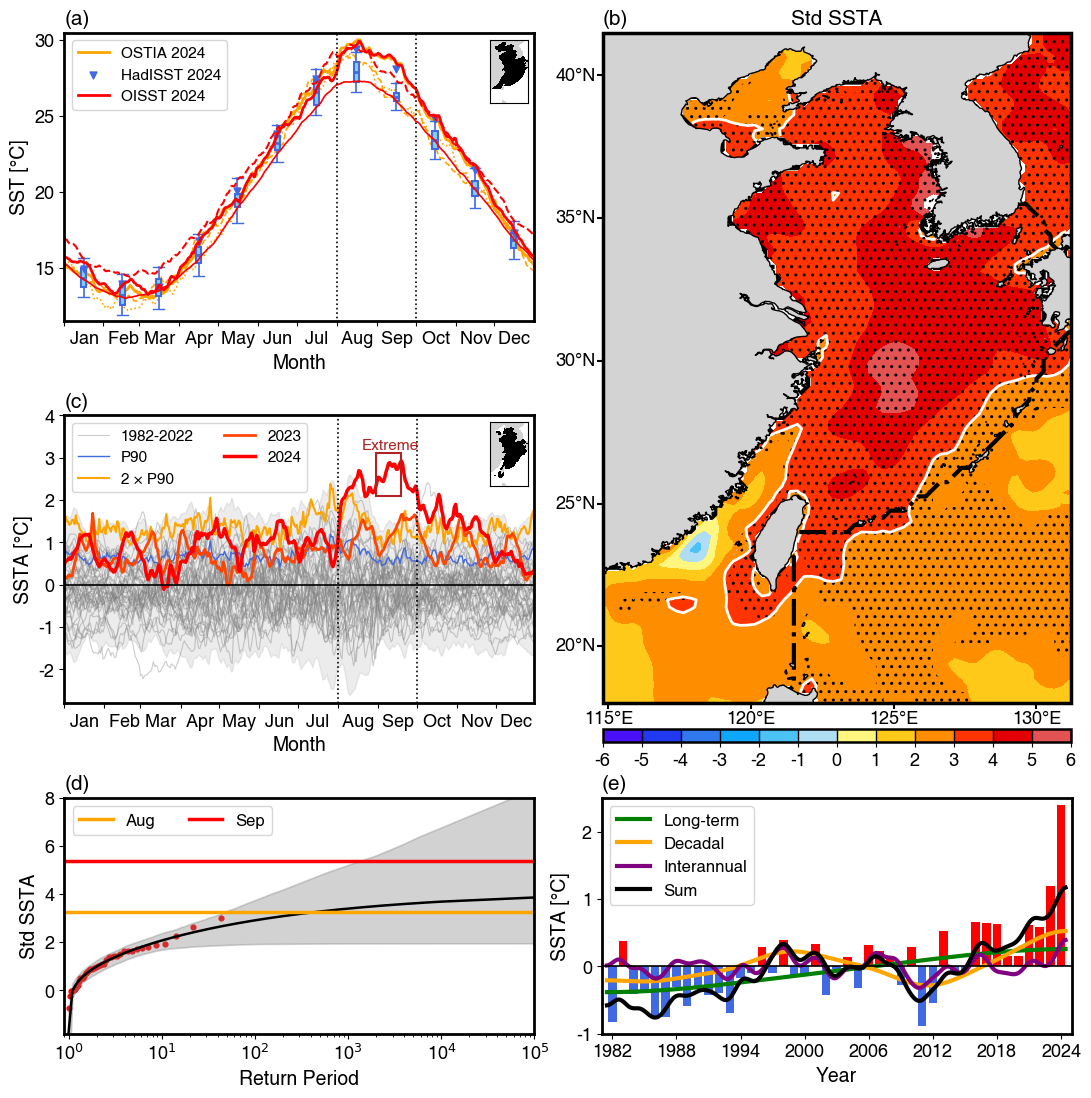

In [13]:
fig = plt.figure(figsize=(13, 13))
fig.subplots_adjust(hspace=0.35,wspace=0)
gs = GridSpec(3, 3, figure=fig,width_ratios=[1.05,0.15,1.05],height_ratios=[1.1,1.1,0.9])

ax0 = fig.add_subplot(gs[0, 0])
# for i in range(42):
#     if i == 41:
#         ax0.plot(np.arange(1,366,1),(sst_all[365*i:365*(i+1)]),'r',lw=0.6,alpha=0.15)
#     else:
#         ax0.plot(np.arange(1,366,1),(sst_all[365*i:365*(i+1)]),'r',lw=0.6,alpha=0.15)
# ax0.plot(np.arange(1,366,1),base_all,color='r',lw=1)
# ax0.plot(np.arange(1,366,1),3*std_all+base_all,color='r',ls='--',lw=1.5)
# ax0.plot(np.arange(1,366,1),sst_all[365*42:],'r',lw=2,label='OISST 2024')

# ax0.plot(np.arange(1,366,1),(sst_all_ostia[365*16:365*17]),'orange',lw=0.8,alpha=1) #2023
ax0.plot(np.arange(1,366,1),(sst_all_ostia[365*9:365*10]),'orange',lw=1.2,ls=':',alpha=1) # 2016
ax0.plot(np.arange(1,366,1),(sst_all_ostia[365*15:365*16]),'orange',lw=1.2,ls='--',alpha=1) # 2022
ax0.plot(np.arange(1,366,1),sst_all_ostia[-365:],'orange',lw=2,label='OSTIA 2024')

box_width = 4
box_t = 15+np.array([1,31,59,90,120,151,181,212,243,273,304,334])

for i in range(12):
    rect = patches.Rectangle((box_t[i] - box_width/2, base_all_hadl[i] - dp90_all_hadl[i]),
                             box_width, 2*dp90_all_hadl[i],
                             edgecolor='royalblue', facecolor='skyblue', linewidth=1.5,zorder=2)
    ax0.add_patch(rect)
    ax0.plot([box_t[i] - box_width/3, box_t[i] + box_width/3],
            [base_all_hadl[i] , base_all_hadl[i]],
            color='royalblue', linewidth=2,zorder=2)
    ax0.plot([box_t[i] - box_width, box_t[i] + box_width],
            [base_all_hadl[i] + 3*std_all_hadl[i], base_all_hadl[i] + 3*std_all_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=1,zorder=2)
    ax0.plot([box_t[i] - box_width, box_t[i] + box_width],
            [base_all_hadl[i] - 3*std_all_hadl[i], base_all_hadl[i] - 3*std_all_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=1,zorder=2)

    ax0.plot([box_t[i], box_t[i]], [base_all_hadl[i] + dp90_all_hadl[i], base_all_hadl[i] + 3*std_all_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=1.2,zorder=2)
    ax0.plot([box_t[i], box_t[i]], [base_all_hadl[i] - dp90_all_hadl[i], base_all_hadl[i] - 3*std_all_hadl[i]],
            linestyle='solid', color='royalblue', linewidth=1.2,zorder=2)

ax0.scatter(box_t,sst_all_hadl[-13:-1], s=25, marker='v', color='royalblue',zorder=2,label='HadISST 2024')

ax0.plot(np.arange(1,366,1),base_all,color='r',lw=1.2)
ax0.plot(np.arange(1,366,1),3*std_all+base_all,color='r',ls='--',lw=1.5)
ax0.plot(np.arange(1,366,1),sst_all[365*42:],'r',lw=2,label='OISST 2024')

ax0.plot([212.5,212.5],[0,40],'k',lw=1.2,ls=':')
ax0.plot([273,273],[0,40],'k',lw=1.2,ls=':')
ax0.set_xlim([1,365])
ax0.set_ylim([11.5,30.5])
ax0.set_xticks([1,31,59,90,120,151,181,212,243,273,304,334],['        Jan','        Feb','        Mar','        Apr','        May','        Jun',
                                                                   '        Jul','        Aug','        Sep','        Oct','        Nov','        Dec'],fontsize=13)
ax0.set_yticks([15,20,25,30],[15,20,25,30],fontsize=13)
ax0.set_xlabel('Month',fontsize=14)
ax0.set_ylabel('SST [°C]',fontsize=14)
ax0.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=11)
ax0.spines[['top','bottom','left','right']].set_linewidth(2)
inset_ax = inset_axes(ax0, width="8%", height="22%", loc="upper right")
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_E_oisst[70:,45:],colors='k')
inset_ax.set_xticks([])
inset_ax.set_yticks([])

ax1 = fig.add_subplot(gs[2, 0])
ax1.scatter(return_periods_his, sorted_ex_his, s=12,c='r')
ax1.plot(RP, RV, lw=1.8,c='k')
ax1.fill_between(RP, ci_lower,ci_upper, lw=1.2,color='grey',alpha=0.35)
ax1.plot([0.1,1e6],[std_sst_high_now[7],std_sst_high_now[7]],'orange',lw=2.5,label='Aug')
ax1.plot([0.1,1e6],[std_sst_high_now[8],std_sst_high_now[8]],'r',lw=2.5,label='Sep')
# ax1.plot([0.1,1e6],[std_sst_high_now[9],std_sst_high_now[9]],'purple',lw=2,label='Oct')
ax1.set_xscale('log')
ax1.set_xlim([0.9,1e5])
ax1.set_ylim([-1.8,8])
ax1.set_xticks([1,10,1e2,1e3,1e4,1e5],['10$^0$','10$^1$','10$^2$','10$^3$','10$^4$','10$^5$'],fontsize=13)
ax1.set_yticks([0,2,4,6,8],[0,2,4,6,8],fontsize=13)
ax1.set_xlabel('Return Period',fontsize=14)
ax1.set_ylabel('Std SSTA',fontsize=14)
ax1.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=3,fontsize=12)
ax1.spines[['top','bottom','left','right']].set_linewidth(2)

ax2 = fig.add_subplot(gs[:2, 2], projection=ccrs.PlateCarree())
ax2.set_extent([116,131,19.8,42])
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=1,zorder=4)
cs = ax2.contourf(sst_ES_oisst.lon, sst_ES_oisst.lat,(np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89)/std_ES_89,
                  levels=np.linspace(-6,6,13),cmap = cmaps.ncl_default,transform=ccrs.PlateCarree())
contour_lines = ax2.contour(
    sst_ES_oisst.lon, sst_ES_oisst.lat, (np.mean(sst_ES_oisst_89[-61:],0)-base_ES_89)/std_ES_89, levels=[3],
    colors='w', linewidths=2, transform=ccrs.PlateCarree())
# ax2.contour(
#     ssh.lon, ssh.lat, ssh, levels=[0.92],
#     colors='purple', linewidths=8, transform=ccrs.PlateCarree())
ax2.contour(
    sst_ES_oisst.lon, sst_ES_oisst.lat, np.isnan(mask_ES_oisst), levels=[0.5,1.5],
    colors='k', linestyles='-.',linewidths=3, transform=ccrs.PlateCarree())
ax2.contourf(
    sst_ES_oisst.lon, sst_ES_oisst.lat, mask_max,
    colors='none',hatches=['..'], transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder=2)
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 13}
gl2.ylabel_style = {'size': 13}
ax2.set_xticks([117, 121, 125, 129])
ax2.set_xticklabels([' ',' ',' ',' '])
ax2.set_yticks([20, 25, 30, 35, 40])
ax2.set_yticklabels([' ',' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([115, 120,125, 130])
gl2.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax2.tick_params(axis='both', length=2, width=1.5)
ax2.spines['geo'].set_linewidth(2.5)
cax = add_bottom_cax_big(ax2,ax2, pad=0.02, width=0.01)
cb =  fig.colorbar(cs,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
cb.set_ticklabels([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6],fontsize=13)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.8)
cb.dividers.set_linewidth(1)

ax3 = fig.add_subplot(gs[1, 0])
for i in range(41):
    if i == 40:
        ax3.plot(date,(sst_high[365*i:365*(i+1)]-base_high),'grey',lw=0.8,alpha=0.4,label='1982-2022')
    else:
        ax3.plot(date,(sst_high[365*i:365*(i+1)]-base_high),'grey',lw=0.8,alpha=0.4)
# ax3.fill_between(date,-std_high,std_high,color='grey',alpha=0.3)
# ax3.fill_between(date,-2*std_high,2*std_high,color='grey',alpha=0.2)
ax3.fill_between(date,-3*std_high,3*std_high,color='grey',alpha=0.15)
ax3.plot(date,(P90_high-base_high),'royalblue',lw=1,label='P90')
ax3.plot(date,2*(P90_high-base_high),'orange',lw=1.5,label='2 × P90')
# ax3.plot(date[4*(P90_high-base_high)<(sst_high[365*42:]-base_high)],4*(P90_high-base_high)[4*(P90_high-base_high)<(sst_high[365*42:]-base_high)],'r',lw=1.5)
# ax3.fill_between(date[241:262],4*(P90_high-base_high)[241:262],
#         (sst_high[365*42:]-base_high)[241:262],color='firebrick',alpha=1)
ax3.plot(date,sst_high[365*41:365*42]-base_high,'orangered',lw=2,label='2023')
ax3.plot(date,sst_high[365*42:]-base_high,'r',lw=2.5,label='2024')
ax3.plot(date,np.zeros(365),'k',lw=1.2)
ax3.plot([date[212],date[212]],[-5,5],'k',lw=1.2,ls=':')
ax3.plot([date[273],date[273]],[-5,5],'k',lw=1.2,ls=':')
ax3.set_xlim([date[0],date[-1]])
ax3.set_ylim([-2.8,4])
ax3.set_xticks(date[[0,31,59,90,120,151,181,212,243,273,304,334]],['        Jan','        Feb','        Mar','        Apr','        May','        Jun',
                                                                   '        Jul','        Aug','        Sep','        Oct','        Nov','        Dec'],fontsize=13)
ax3.set_yticks([-2,-1,0,1,2,3,4],[-2,-1,0,1,2,3,4],fontsize=13)
ax3.set_xlabel('Month',fontsize=14)
ax3.set_ylabel('SSTA [°C]',fontsize=14)
ax3.text(date[230],3.2,'Extreme',color='firebrick',fontsize=11)
rect1 = patches.Rectangle((date[241], 2.1),
                             date[261]-date[241], 1,
                             edgecolor='firebrick', facecolor='None', linewidth=1.5,zorder=2)
ax3.add_patch(rect1)
# ax3.plot([date[241],date[241]],[2.1,3.1], color='firebrick', lw=1.5)
# ax3.plot([date[261],date[261]],[2.1,3.1], color='firebrick', lw=1.5)
ax3.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=2,fontsize=11)
ax3.spines[['top','bottom','left','right']].set_linewidth(2)
inset_ax = inset_axes(ax3, width="8%", height="22%", loc="upper right")
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_hightemp[70:,45:],colors='k')
inset_ax.set_xticks([])
inset_ax.set_yticks([])

ax4 = fig.add_subplot(gs[2, 2])
colors = ['r' if val > 0 else 'royalblue' for val in year_high_89-np.mean(year_high_89[9:39])]

ax4.bar(np.linspace(0,42,43),year_high_89-np.mean(year_high_89[9:39]),color=colors)
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_long_high,color='green',lw=3,label='Long-term')
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_multidecad_high,color='orange',lw=3,label='Decadal')
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_intan_high,color='purple',lw=3,label='Interannual')
ax4.plot(np.linspace(-0.5,42.5-1/12,43*12),t_intan_high+t_multidecad_high+t_long_high,color='k',lw=3,label='Sum')
ax4.plot(np.arange(-1,44),np.zeros(45),'k',lw=1.2)
ax4.set_xlim([-1,43])
ax4.set_ylim([-1,2.5])
ax4.set_xticks(np.arange(43)[::6],np.arange(1982,2025)[::6],fontsize=13)
ax4.set_yticks([-1,0,1,2],[-1,0,1,2],fontsize=13)
ax4.set_xlabel('Year',fontsize=14)
ax4.set_ylabel('SSTA [°C]',fontsize=14)
ax4.legend(loc='upper left',bbox_to_anchor=(0,1),fontsize=12)
ax4.spines[['top','bottom','left','right']].set_linewidth(2)

ax0.set_title('(a)',fontsize=15,loc='left')
ax1.set_title('(d)',fontsize=15,loc='left')
ax2.set_title('(b)',fontsize=15,loc='left')
ax2.set_title('Std SSTA',fontsize=15)
ax3.set_title('(c)',fontsize=15,loc='left')
ax4.set_title('(e)',fontsize=15,loc='left')

In [22]:
(year_high_89-np.mean(year_high_89[9:39]))[-1]- (sel_year_1d(t_long_high,8,9)[-1]+sel_year_1d(t_multidecad_high,8,9)[-1]+sel_year_1d(t_intan_high,8,9)[-1])

1.2632073760032654

In [23]:
1 - (sel_year_1d(t_long_high,8,9)[-1]+sel_year_1d(t_multidecad_high,8,9)[-1]+sel_year_1d(t_intan_high,8,9)[-1])/(year_high_89-np.mean(year_high_89[9:39]))[-1]

0.5267722956850269

In [237]:
np.where(4*(P90_high-base_high)<(sst_high[365*42:]-base_high))

(array([241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253,
        254, 255, 256, 257, 258, 259, 260, 261, 272]),)

In [81]:
date[208:220]

DatetimeIndex(['2023-07-29', '2023-07-30', '2023-07-31', '2023-08-01',
               '2023-08-02', '2023-08-03', '2023-08-04', '2023-08-05',
               '2023-08-06', '2023-08-07', '2023-08-08'],
              dtype='datetime64[ns]', freq='D')

In [84]:
(sst_high[365*42:]-base_high)[208:220]

array([0.42550087, 0.5193844 , 0.6420822 , 0.81907845, 1.1032658 ,
       1.4596901 , 1.8428726 , 1.991478  , 2.038557  , 2.05764   ,
       2.132349  , 2.2223854 ], dtype=float32)

In [85]:
((sst_high[365*42:]-base_high)/std_high)[208:220]

array([0.51935726, 0.6586834 , 0.88596267, 1.235336  , 1.7311487 ,
       2.2464695 , 2.9377193 , 3.215893  , 3.2053354 , 2.9954603 ,
       2.8543139 , 2.7107513 ], dtype=float32)

In [26]:
np.min((sst_high[365*42:]-base_high)[200:273]), np.max((sst_high[365*42:]-base_high)[200:273])

(0.42550087, 2.9247074)

Text(0.0, 1.0, '(b)')

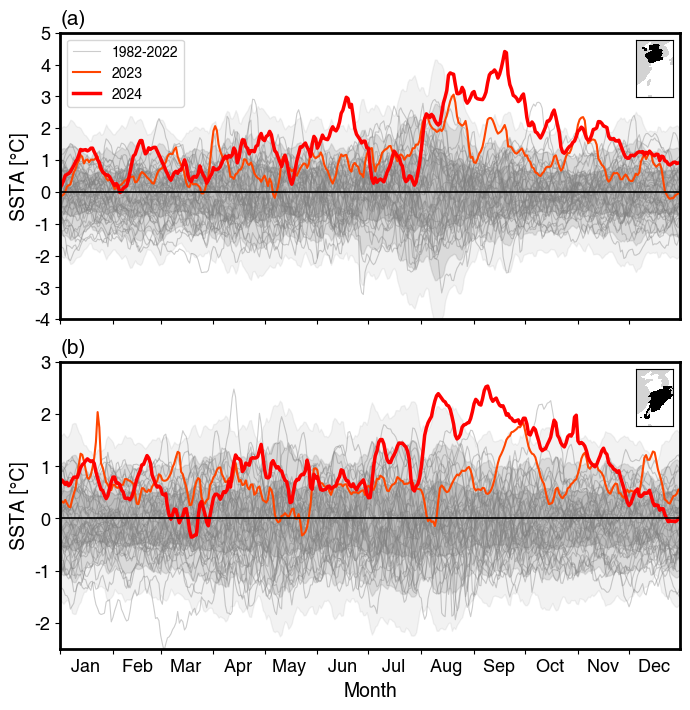

In [18]:
fig = plt.figure(figsize=(8, 8))
fig.subplots_adjust(hspace=0.15,wspace=-0.1)
gs = GridSpec(2, 1, figure=fig)

ax0 = fig.add_subplot(gs[0, 0])
for i in range(41):
    if i == 40:
        ax0.plot(date,(sst_high_YS[365*i:365*(i+1)]-base_high_YS),'grey',lw=0.8,alpha=0.4,label='1982-2022')
    else:
        ax0.plot(date,(sst_high_YS[365*i:365*(i+1)]-base_high_YS),'grey',lw=0.8,alpha=0.4)
ax0.fill_between(date,-std_high_YS,std_high_YS,color='grey',alpha=0.3)
ax0.fill_between(date,-2*std_high_YS,2*std_high_YS,color='grey',alpha=0.2)
ax0.fill_between(date,-3*std_high_YS,3*std_high_YS,color='grey',alpha=0.1)
ax0.plot(date,(sst_high_YS[365*41:365*42]-base_high_YS),'orangered',lw=1.5,label='2023')
ax0.plot(date,sst_high_YS[365*42:]-base_high_YS,'r',lw=2.5,label='2024')
ax0.plot(date,np.zeros(365),'k',lw=1.2)
ax0.set_xlim([date[0],date[-1]])
ax0.set_ylim([-4,5])
ax0.set_xticks(date[[0,31,59,90,120,151,181,212,243,273,304,334]],['         ','         ','         ','         ','         ','         ',
                                                                   '         ','         ','         ','         ','         ','         '],fontsize=13)
ax0.set_yticks([-4,-3,-2,-1,0,1,2,3,4,5],[-4,-3,-2,-1,0,1,2,3,4,5],fontsize=13)
# ax0.set_xlabel('Month',fontsize=14)
ax0.set_ylabel('SSTA [°C]',fontsize=14)
ax0.legend(loc='upper left',bbox_to_anchor=(0,1))
ax0.spines[['top','bottom','left','right']].set_linewidth(2)
inset_ax = inset_axes(ax0, width="6%", height="20%", loc="upper right")
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_YS[70:,45:],colors='k')
inset_ax.set_xticks([])
inset_ax.set_yticks([])

ax1 = fig.add_subplot(gs[1, 0])
for i in range(41):
    if i == 40:
        ax1.plot(date,(sst_high_ECS[365*i:365*(i+1)]-base_high_ECS),'grey',lw=0.8,alpha=0.4,label='1982-2022')
    else:
        ax1.plot(date,(sst_high_ECS[365*i:365*(i+1)]-base_high_ECS),'grey',lw=0.8,alpha=0.4)
ax1.fill_between(date,-std_high_ECS,std_high_ECS,color='grey',alpha=0.3)
ax1.fill_between(date,-2*std_high_ECS,2*std_high_ECS,color='grey',alpha=0.2)
ax1.fill_between(date,-3*std_high_ECS,3*std_high_ECS,color='grey',alpha=0.1)
ax1.plot(date,(sst_high_ECS[365*41:365*42]-base_high_ECS),'orangered',lw=1.5,label='2023')
ax1.plot(date,sst_high_ECS[365*42:]-base_high_ECS,'r',lw=2.5,label='2024')
ax1.plot(date,np.zeros(365),'k',lw=1.2)
ax1.set_xlim([date[0],date[-1]])
ax1.set_ylim([-2.5,3])
ax1.set_xticks(date[[0,31,59,90,120,151,181,212,243,273,304,334]],['          Jan','          Feb','          Mar','          Apr','          May','          Jun',
                                                                   '          Jul','          Aug','          Sep','          Oct','          Nov','          Dec'],fontsize=13)
ax1.set_yticks([-2,-1,0,1,2,3],[-2,-1,0,1,2,3],fontsize=13)
ax1.set_xlabel('Month',fontsize=14)
ax1.set_ylabel('SSTA [°C]',fontsize=14)
ax1.spines[['top','bottom','left','right']].set_linewidth(2)
inset_ax = inset_axes(ax1, width="6%", height="20%", loc="upper right")
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_ECS[70:,45:],colors='k')
inset_ax.set_xticks([])
inset_ax.set_yticks([])

ax0.set_title('(a)',fontsize=15,loc='left')
ax1.set_title('(b)',fontsize=15,loc='left')

### mechanism

In [14]:
# print('Open wind_press')
# da = xr.open_dataset('./ERA5/wind_pres.nc')
# da = da.reindex(latitude=list(reversed(da.latitude))).sel(valid_time=da['valid_time'].dt.month.isin(4),longitude=slice(70,160),
#             latitude=slice(10,60)).groupby('valid_time.year').mean(dim='valid_time')
# u10_4 = np.array(da.u10)
# v10_4 = np.array(da.v10)
# slp_4 = np.array(da.msl)

# print('Open rain_flux')
# da1 = xr.open_dataset('./ERA5/rain_flux.nc')
# da1 = da1.reindex(latitude=list(reversed(da1.latitude))).sel(valid_time=da1['valid_time'].dt.month.isin(4),longitude=slice(70,160),
#               latitude=slice(10,60)).groupby('valid_time.year').mean(dim='valid_time')
# shf_4 = np.array(da1.msshf)
# lhf_4 = np.array(da1.mslhf)
# sw_4 = np.array(da1.msnswrf)
# lw_4 = np.array(da1.msnlwrf)
# rain_4 = np.array(da1.tp)

# print('Open temp')
# da2 = xr.open_dataset('./ERA5/Temp.nc')
# da2 = da2.reindex(latitude=list(reversed(da2.latitude))).sel(valid_time=da2['valid_time'].dt.month.isin(4),longitude=slice(70,160),
#               latitude=slice(10,60)).groupby('valid_time.year').mean(dim='valid_time')
# atm_T_4 = np.array(da2.t2m)
# atm_dewT_4 = np.array(da2.d2m)

# print('Open cloud')
# da3 = xr.open_dataset('./ERA5/cloud.nc')
# da3 = da3.reindex(latitude=list(reversed(da3.latitude))).sel(valid_time=da3['valid_time'].dt.month.isin(4),longitude=slice(70,160),
#               latitude=slice(10,60)).groupby('valid_time.year').mean(dim='valid_time')
# cloud_4 = np.array(da3.tcc)

# print('Open Z')
# da4 = xr.open_dataset('./ERA5/press_high.nc')
# da4 = da4.reindex(latitude=list(reversed(da4.latitude))).sel(valid_time=da4['valid_time'].dt.month.isin(4),longitude=slice(70,160),
#               latitude=slice(10,60)).groupby('valid_time.year').mean(dim='valid_time').squeeze()
# Phigh_4 = np.array(da4.z)/9.8

# print('Open sst')
# da5 = xr.open_dataset('./ERA5/sst.nc')
# da5 = da5.reindex(latitude=list(reversed(da5.latitude))).sel(valid_time=da5['valid_time'].dt.month.isin(4),longitude=slice(70,160),
#               latitude=slice(10,60)).groupby('valid_time.year').mean(dim='valid_time')
# ocn_T_4 = np.array(da5.sst)

In [15]:
print('Open wind_press')
da = xr.open_dataset('./ERA5/wind_pres.nc')
da = da.reindex(latitude=list(reversed(da.latitude))).interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
u10_8 = np.array(da.sel(valid_time=da['valid_time'].dt.month.isin(8)).u10)
v10_8 = np.array(da.sel(valid_time=da['valid_time'].dt.month.isin(8)).v10)
slp_8 = np.array(da.sel(valid_time=da['valid_time'].dt.month.isin(8)).msl)
u10_9 = np.array(da.sel(valid_time=da['valid_time'].dt.month.isin(9)).u10)
v10_9 = np.array(da.sel(valid_time=da['valid_time'].dt.month.isin(9)).v10)
slp_9 = np.array(da.sel(valid_time=da['valid_time'].dt.month.isin(9)).msl)

print('Open rain_flux')
da1 = xr.open_dataset('./ERA5/rain_flux.nc')
da1 = da1.reindex(latitude=list(reversed(da1.latitude))).interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
# shf_7 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(7)).msshf)
# lhf_7 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(7)).mslhf)
# sw_7 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(7)).msnswrf)
# lw_7 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(7)).msnlwrf)
shf_8 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(8)).msshf)
lhf_8 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(8)).mslhf)
sw_8 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(8)).msnswrf)
lw_8 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(8)).msnlwrf)
shf_9 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(9)).msshf)
lhf_9 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(9)).mslhf)
sw_9 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(9)).msnswrf)
lw_9 = np.array(da1.sel(valid_time=da1['valid_time'].dt.month.isin(9)).msnlwrf)

print('Open temp')
da2 = xr.open_dataset('./ERA5/Temp.nc')
da2 = da2.reindex(latitude=list(reversed(da2.latitude))).interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
atm_T_8 = np.array(da2.sel(valid_time=da2['valid_time'].dt.month.isin(8)).t2m)
atm_dewT_8 = np.array(da2.sel(valid_time=da2['valid_time'].dt.month.isin(8)).d2m)
atm_T_9 = np.array(da2.sel(valid_time=da2['valid_time'].dt.month.isin(9)).t2m)
atm_dewT_9 = np.array(da2.sel(valid_time=da2['valid_time'].dt.month.isin(9)).d2m)

print('Open cloud')
da3 = xr.open_dataset('./ERA5/cloud.nc')
da3 = da3.reindex(latitude=list(reversed(da3.latitude))).interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
cloud_8 = np.array(da3.sel(valid_time=da3['valid_time'].dt.month.isin(8)).tcc)
cloud_9 = np.array(da3.sel(valid_time=da3['valid_time'].dt.month.isin(9)).tcc)
print('Open Z')
da4 = xr.open_dataset('./ERA5/press_high.nc')
da4 = da4.reindex(latitude=list(reversed(da4.latitude))).interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
Phigh_8 = np.array(da4.sel(valid_time=da4['valid_time'].dt.month.isin(8)).z)/9.8
Phigh_9 = np.array(da4.sel(valid_time=da4['valid_time'].dt.month.isin(9)).z)/9.8

print('Open sst')
da5 = xr.open_dataset('./ERA5/sst.nc')
da5 = da5.reindex(latitude=list(reversed(da5.latitude))).interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
ocn_T_8 = np.array(da5.sel(valid_time=da5['valid_time'].dt.month.isin(8)).sst)
ocn_T_9 = np.array(da5.sel(valid_time=da5['valid_time'].dt.month.isin(9)).sst)

Open wind_press
Open rain_flux
Open temp
Open cloud
Open Z
Open sst


In [29]:
# RH_4 = 100*np.exp(17.625*atm_dewT_4/(243.04+atm_dewT_4)-17.625*atm_T_4/(243.04+atm_T_4))   # https://doi.org/10.1175/BAMS-86-2-225.
# # 8-9月  气温比海温低
# e_atm_4 = RH_4/100*6.112*np.exp(17.67*atm_T_4/(atm_T_4+243.5))
# q_atm_4 = 0.622*e_atm_4/(slp_4-0.378*e_atm_4)

# e_ocn_4 = 6.112*np.exp(17.67*ocn_T_4/(ocn_T_4+243.5))
# q_ocn_4= 0.622*e_atm_4/(slp_4-0.378*e_ocn_4)

In [16]:
RH_8 = 100*np.exp(17.625*atm_dewT_8/(243.04+atm_dewT_8)-17.625*atm_T_8/(243.04+atm_T_8))   # https://doi.org/10.1175/BAMS-86-2-225.
# 8-9月  气温比海温低
e_atm_8 = RH_8/100*6.112*np.exp(17.67*atm_T_8/(atm_T_8+243.5))
q_atm_8 = 0.622*e_atm_8/(slp_8-0.378*e_atm_8)

e_ocn_8 = 6.112*np.exp(17.67*ocn_T_8/(ocn_T_8+243.5))
q_ocn_8= 0.622*e_atm_8/(slp_8-0.378*e_ocn_8)

In [17]:
RH_9 = 100*np.exp(17.625*atm_dewT_9/(243.04+atm_dewT_9)-17.625*atm_T_9/(243.04+atm_T_9))   # https://doi.org/10.1175/BAMS-86-2-225.
# 8-9月  气温比海温低
e_atm_9 = RH_9/100*6.112*np.exp(17.67*atm_T_9/(atm_T_9+243.5))
q_atm_9 = 0.622*e_atm_9/(slp_9-0.378*e_atm_9)

e_ocn_9 = 6.112*np.exp(17.67*ocn_T_9/(ocn_T_9+243.5))
q_ocn_9 = 0.622*e_atm_9/(slp_9-0.378*e_ocn_9)

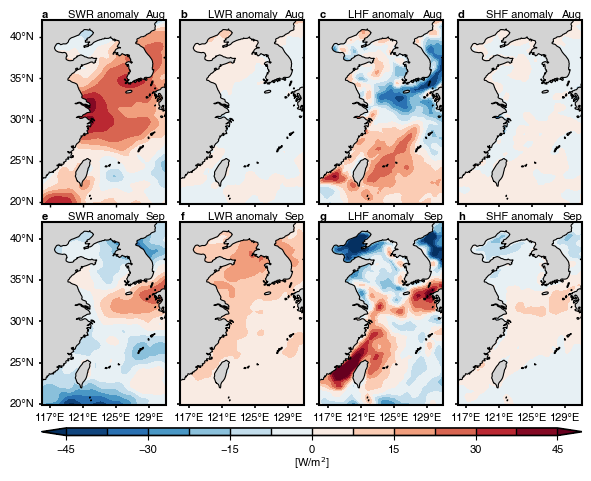

In [94]:
fig = plt.figure(figsize=(7, 5))
fig.subplots_adjust(wspace=0.1,hspace=0.1)
gs = GridSpec(2, 4 , figure=fig,height_ratios=[1,1])

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs = ax.contourf(da.longitude,da.latitude,(sw_8[-1]-np.mean(sw_8[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl =ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl.left_labels = True
# gl.bottom_labels = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
ax.set_xticks([117, 121, 125, 129])
ax.set_xticklabels([' ',' ',' ',' '])
ax.set_yticks([20, 25, 30, 35, 40])
ax.set_yticklabels([' ',' ',' ',' ',' '])
gl.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax.tick_params(axis='both', length=2, width=1)

ax0 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax0.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax0.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs0 = ax0.contourf(da.longitude,da.latitude,(lw_8[-1]-np.mean(lw_8[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl0 =ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl0.bottom_labels = True
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
gl0.xlabel_style = {'size': 8}
gl0.ylabel_style = {'size': 8}
ax0.set_xticks([117, 121, 125, 129])
ax0.set_xticklabels([' ',' ',' ',' '])
ax0.set_yticks([20, 25, 30, 35, 40])
ax0.set_yticklabels([' ',' ',' ',' ',' '])
gl0.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl0.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax0.tick_params(axis='both', length=2, width=1.2)

ax1 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax1.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs1 = ax1.contourf(da.longitude,da.latitude,(lhf_8[-1]-np.mean(lhf_8[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl1 =ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 8}
gl1.ylabel_style = {'size': 8}
ax1.set_xticks([117, 121, 125, 129])
ax1.set_xticklabels([' ',' ',' ',' '])
ax1.set_yticks([20, 25, 30, 35, 40])
ax1.set_yticklabels([' ',' ',' ',' ',' '])
gl1.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl1.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax1.tick_params(axis='both', length=2, width=1.2)

ax2 = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
ax2.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs2 = ax2.contourf(da.longitude,da.latitude,(shf_8[-1]-np.mean(shf_8[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([117, 121, 125, 129])
ax2.set_xticklabels([' ',' ',' ',' '])
ax2.set_yticks([20, 25, 30, 35, 40])
ax2.set_yticklabels([' ',' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl2.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax2.tick_params(axis='both', length=2, width=1.2)

ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs4 = ax4.contourf(da.longitude,da.latitude,(sw_9[-1]-np.mean(sw_9[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl4 =ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl4.left_labels = True
gl4.bottom_labels = True
gl4.xformatter = LONGITUDE_FORMATTER
gl4.yformatter = LATITUDE_FORMATTER
gl4.xlabel_style = {'size': 8}
gl4.ylabel_style = {'size': 8}
ax4.set_xticks([117, 121, 125, 129])
ax4.set_xticklabels([' ',' ',' ',' '])
ax4.set_yticks([20, 25, 30, 35, 40])
ax4.set_yticklabels([' ',' ',' ',' ',' '])
gl4.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl4.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax4.tick_params(axis='both', length=2, width=1.2)

ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax5.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax5.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax5.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs5 = ax5.contourf(da.longitude,da.latitude,(lw_9[-1]-np.mean(lw_9[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl5 =ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl5.bottom_labels = True
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER
gl5.xlabel_style = {'size': 8}
gl5.ylabel_style = {'size': 8}
ax5.set_xticks([117, 121, 125, 129])
ax5.set_xticklabels([' ',' ',' ',' '])
ax5.set_yticks([20, 25, 30, 35, 40])
ax5.set_yticklabels([' ',' ',' ',' ',' '])
gl5.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl5.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax5.tick_params(axis='both', length=2, width=1.2)

ax6 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
ax6.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax6.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs6 = ax6.contourf(da.longitude,da.latitude,(lhf_9[-1]-np.mean(lhf_9[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl6 =ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl6.bottom_labels = True
gl6.xformatter = LONGITUDE_FORMATTER
gl6.yformatter = LATITUDE_FORMATTER
gl6.xlabel_style = {'size': 8}
gl6.ylabel_style = {'size': 8}
ax6.set_xticks([117, 121, 125, 129])
ax6.set_xticklabels([' ',' ',' ',' '])
ax6.set_yticks([20, 25, 30, 35, 40])
ax6.set_yticklabels([' ',' ',' ',' ',' '])
gl6.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl6.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax6.tick_params(axis='both', length=2, width=1.2)

ax7 = fig.add_subplot(gs[1, 3], projection=ccrs.PlateCarree())
ax7.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax7.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs7 = ax7.contourf(da.longitude,da.latitude,(shf_9[-1]-np.mean(shf_9[10:40],0)),
                    levels= np.linspace(-45,45,13),cmap='RdBu_r',extend='both')
gl7 =ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl7.bottom_labels = True
gl7.xformatter = LONGITUDE_FORMATTER
gl7.yformatter = LATITUDE_FORMATTER
gl7.xlabel_style = {'size': 8}
gl7.ylabel_style = {'size': 8}
ax7.set_xticks([117, 121, 125, 129])
ax7.set_xticklabels([' ',' ',' ',' '])
ax7.set_yticks([20, 25, 30, 35, 40])
ax7.set_yticklabels([' ',' ',' ',' ',' '])
gl7.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl7.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax7.tick_params(axis='both', length=2, width=1.2)

cax = add_bottom_cax_big(ax4,ax7, pad=0.045, width=0.015)
cb =  fig.colorbar(cs4,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-45,-30,-15,0,15,30,45])
cb.set_ticklabels(['−45','−30','−15','0','15','30','45'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('[W/m$^2$]',fontsize=8,labelpad=0)

ax.spines['geo'].set_linewidth(1.5)
ax0.spines['geo'].set_linewidth(1.5)
ax1.spines['geo'].set_linewidth(1.5)
ax2.spines['geo'].set_linewidth(1.5)
ax4.spines['geo'].set_linewidth(1.5)
ax5.spines['geo'].set_linewidth(1.5)
ax6.spines['geo'].set_linewidth(1.5)
ax7.spines['geo'].set_linewidth(1.5)

ax.set_title('SWR anomaly',fontsize=8,pad=2)
ax0.set_title('LWR anomaly',fontsize=8,pad=2)
ax1.set_title('LHF anomaly',fontsize=8,pad=2)
ax2.set_title('SHF anomaly',fontsize=8,pad=2)
ax4.set_title('SWR anomaly',fontsize=8,pad=2)
ax5.set_title('LWR anomaly',fontsize=8,pad=2)
ax6.set_title('LHF anomaly',fontsize=8,pad=2)
ax7.set_title('SHF anomaly',fontsize=8,pad=2)


ax.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax0.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
ax1.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('d',fontsize=8,loc='left',fontweight='bold',pad=2)
ax4.set_title('e',fontsize=8,loc='left',fontweight='bold',pad=2)
ax5.set_title('f',fontsize=8,loc='left',fontweight='bold',pad=2)
ax6.set_title('g',fontsize=8,loc='left',fontweight='bold',pad=2)
ax7.set_title('h',fontsize=8,loc='left',fontweight='bold',pad=2)

ax.set_title('Aug',fontsize=8,loc='right',pad=2)
ax0.set_title('Aug',fontsize=8,loc='right',pad=2)
ax1.set_title('Aug',fontsize=8,loc='right',pad=2)
ax2.set_title('Aug',fontsize=8,loc='right',pad=2)
ax4.set_title('Sep',fontsize=8,loc='right',pad=2)
ax5.set_title('Sep',fontsize=8,loc='right',pad=2)
ax6.set_title('Sep',fontsize=8,loc='right',pad=2)
ax7.set_title('Sep',fontsize=8,loc='right',pad=2)

fig.savefig('./fig/FigS3.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

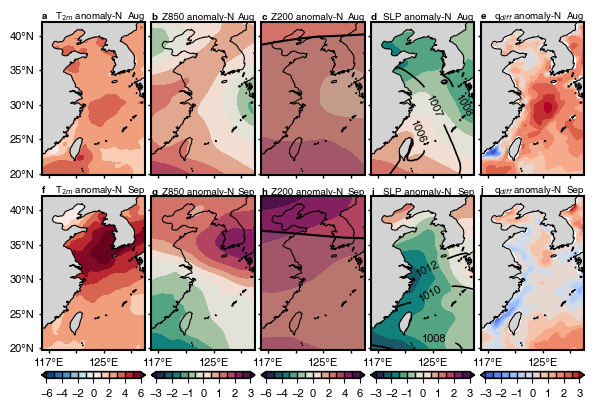

In [98]:
fig = plt.figure(figsize=(7, 4.4))
fig.subplots_adjust(wspace=0.06,hspace=0.06)
gs = GridSpec(2, 5 , figure=fig)

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs = ax.contourf(da.longitude,da.latitude,(atm_T_8[-1]-np.mean(atm_T_8[10:40],0))/np.std(atm_T_8[10:40],0),
                    levels= np.linspace(-6,6,13),cmap='RdBu_r',extend='both')
gl =ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl.left_labels = True
# gl.bottom_labels = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
ax.set_xticks([117, 121, 125, 129])
ax.set_xticklabels([' ',' ',' ',' '])
ax.set_yticks([20, 25, 30, 35, 40])
ax.set_yticklabels([' ',' ',' ',' ',' '])
gl.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax.tick_params(axis='both', length=2, width=1)

ax00 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax00.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax00.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax00.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs00 = ax00.contourf(da.longitude,da.latitude,(Phigh_8[-1,0]-np.mean(Phigh_8[10:40,0],0))/np.std(Phigh_8[10:40,0],0),
                    levels= np.linspace(-3,3,13),cmap=cmaps.cmocean_curl,extend='both')
gl00 =ax00.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl00.left_labels = True
# gl00.bottom_labels = True
gl00.xformatter = LONGITUDE_FORMATTER
gl00.yformatter = LATITUDE_FORMATTER
gl00.xlabel_style = {'size': 8}
gl00.ylabel_style = {'size': 8}
ax00.set_xticks([117, 121, 125, 129])
ax00.set_xticklabels([' ',' ',' ',' '])
ax00.set_yticks([20, 25, 30, 35, 40])
ax00.set_yticklabels([' ',' ',' ',' ',' '])
gl00.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl00.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax00.tick_params(axis='both', length=2, width=1)

ax0 = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
ax0.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax0.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs0 = ax0.contourf(da.longitude,da.latitude,(slp_8[-1]-np.mean(slp_8[10:40],0))/np.std(slp_8[10:40],0),
                    levels= np.linspace(-3,3,13),cmap=cmaps.cmocean_curl,extend='both')
cc = ax0.contour(da.longitude,da.latitude,np.mean(slp_8[10:40],0)/100,levels= [1006,1007,1008],
        colors='k',linewidths=1.2,zorder=1)
ax0.clabel(cc,inline=True,inline_spacing=10,
                  manual=[(122,26), (125.5, 30), (129.5, 30)],fontsize=8)
gl0 =ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl0.bottom_labels = True
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
gl0.xlabel_style = {'size': 8}
gl0.ylabel_style = {'size': 8}
ax0.set_xticks([117, 121, 125, 129])
ax0.set_xticklabels([' ',' ',' ',' '])
ax0.set_yticks([20, 25, 30, 35, 40])
ax0.set_yticklabels([' ',' ',' ',' ',' '])
gl0.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl0.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax0.tick_params(axis='both', length=2, width=1)

ax2 = fig.add_subplot(gs[0, 4], projection=ccrs.PlateCarree())
ax2.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs2 = ax2.contourf(da.longitude,da.latitude,((q_ocn_8-q_atm_8)[-1]-np.mean((q_ocn_8-q_atm_8)[10:40],0))/np.std((q_ocn_8-q_atm_8)[10:40],0),
                    levels= np.linspace(-3,3,13),cmap='coolwarm',extend='both')
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl2.bottom_labels = True
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([117, 121, 125, 129])
ax2.set_xticklabels([' ',' ',' ',' '])
ax2.set_yticks([20, 25, 30, 35, 40])
ax2.set_yticklabels([' ',' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl2.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax2.tick_params(axis='both', length=2, width=1)

ax1 = fig.add_subplot(gs[1, 3], projection=ccrs.PlateCarree())
ax1.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs1 = ax1.contourf(da.longitude,da.latitude,(slp_9[-1]-np.mean(slp_9[10:40],0))/np.std(slp_9[10:40],0),
                    levels= np.linspace(-3,3,13),cmap=cmaps.cmocean_curl,extend='both')
cc1 = ax1.contour(da.longitude,da.latitude,np.mean(slp_9[10:40],0)/100,levels= [1008,1010,1012],
            colors='k',linewidths=1.2,zorder=1)
ax1.clabel(cc1,inline=True,inline_spacing=10,
                  manual=[(125, 21), (125, 27.5), (124, 32)],fontsize=8)
gl1 =ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl1.bottom_labels = True
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 8}
gl1.ylabel_style = {'size': 8}
ax1.set_xticks([117, 121, 125, 129])
ax1.set_xticklabels([' ',' ',' ',' '])
ax1.set_yticks([20, 25, 30, 35, 40])
ax1.set_yticklabels([' ',' ',' ',' ',' '])
gl1.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl1.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax1.tick_params(axis='both', length=2, width=1)

ax3 = fig.add_subplot(gs[1, 4], projection=ccrs.PlateCarree())
ax3.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax3.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs3 = ax3.contourf(da.longitude,da.latitude,((q_ocn_9-q_atm_9)[-1]-np.mean((q_ocn_9-q_atm_9)[10:40],0))/np.std((q_ocn_9-q_atm_9)[10:40],0),
                    levels= np.linspace(-3,3,13),cmap='coolwarm',extend='both')
gl3 =ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl3.bottom_labels = True
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER
gl3.xlabel_style = {'size': 8}
gl3.ylabel_style = {'size': 8}
ax3.set_xticks([117, 121, 125, 129])
ax3.set_xticklabels([' ',' ',' ',' '])
ax3.set_yticks([20, 25, 30, 35, 40])
ax3.set_yticklabels([' ',' ',' ',' ',' '])
gl3.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl3.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax3.tick_params(axis='both', length=2, width=1)

ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs4 = ax4.contourf(da.longitude,da.latitude,(atm_T_9[-1]-np.mean(atm_T_9[10:40],0))/np.std(atm_T_9[10:40],0),
                    levels= np.linspace(-6,6,13),cmap='RdBu_r',extend='both')
gl4 =ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl4.left_labels = True
gl4.bottom_labels = True
gl4.xformatter = LONGITUDE_FORMATTER
gl4.yformatter = LATITUDE_FORMATTER
gl4.xlabel_style = {'size': 8}
gl4.ylabel_style = {'size': 8}
ax4.set_xticks([117, 121, 125, 129])
ax4.set_xticklabels([' ',' ',' ',' '])
ax4.set_yticks([20, 25, 30, 35, 40])
ax4.set_yticklabels([' ',' ',' ',' ',' '])
gl4.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl4.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax4.tick_params(axis='both', length=2, width=1)


ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax5.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax5.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax5.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs5 = ax5.contourf(da.longitude,da.latitude,(Phigh_9[-1,0]-np.mean(Phigh_9[10:40,0],0))/np.std(Phigh_9[10:40,0],0),
                    levels= np.linspace(-3,3,13),cmap=cmaps.cmocean_curl,extend='both')
gl5 =ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl5.left_labels = True
gl5.bottom_labels = True
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER
gl5.xlabel_style = {'size': 8}
gl5.ylabel_style = {'size': 8}
ax5.set_xticks([117, 121, 125, 129])
ax5.set_xticklabels([' ',' ',' ',' '])
ax5.set_yticks([20, 25, 30, 35, 40])
ax5.set_yticklabels([' ',' ',' ',' ',' '])
gl5.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl5.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax5.tick_params(axis='both', length=2, width=1)


ax10 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax10.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax10.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax10.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs10 = ax10.contourf(da.longitude,da.latitude,(Phigh_8[-1,3]-np.mean(Phigh_8[10:40,3],0))/np.std(Phigh_8[10:40,3],0),
                    levels= np.linspace(-6,6,13),cmap=cmaps.cmocean_curl,extend='both')
ax10.contourf(da.longitude,da.latitude,Phigh_8[-1,3],levels= [12500,15000],colors='grey',alpha=0.3, transform=ccrs.PlateCarree())
ax10.contour(da.longitude,da.latitude,Phigh_8[-1,3],levels= [12500],colors='k',linewidths=1.5,zorder=1)
gl10 =ax10.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl00.left_labels = True
# gl00.bottom_labels = True
gl10.xformatter = LONGITUDE_FORMATTER
gl10.yformatter = LATITUDE_FORMATTER
gl10.xlabel_style = {'size': 8}
gl10.ylabel_style = {'size': 8}
ax10.set_xticks([117, 121, 125, 129])
ax10.set_xticklabels([' ',' ',' ',' '])
ax10.set_yticks([20, 25, 30, 35, 40])
ax10.set_yticklabels([' ',' ',' ',' ',' '])
gl10.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl10.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax10.tick_params(axis='both', length=2, width=1)

ax11 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
ax11.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax11.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax11.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs11 = ax11.contourf(da.longitude,da.latitude,(Phigh_9[-1,3]-np.mean(Phigh_9[10:40,3],0))/np.std(Phigh_9[10:40,3],0),
                    levels= np.linspace(-6,6,13),cmap=cmaps.cmocean_curl,extend='both')
ax11.contourf(da.longitude,da.latitude,Phigh_9[-1,3],levels= [12500,15000],colors='grey',alpha=0.3, transform=ccrs.PlateCarree())
ax11.contour(da.longitude,da.latitude,Phigh_9[-1,3],levels= [12500],colors='k',linewidths=1.5,zorder=1)
gl11 =ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl00.left_labels = True
gl11.bottom_labels = True
gl11.xformatter = LONGITUDE_FORMATTER
gl11.yformatter = LATITUDE_FORMATTER
gl11.xlabel_style = {'size': 8}
gl11.ylabel_style = {'size': 8}
ax11.set_xticks([117, 121, 125, 129])
ax11.set_xticklabels([' ',' ',' ',' '])
ax11.set_yticks([20, 25, 30, 35, 40])
ax11.set_yticklabels([' ',' ',' ',' ',' '])
gl11.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl11.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax11.tick_params(axis='both', length=2, width=1)

cax = add_bottom_cax_big(ax4,ax4, pad=0.05, width=0.015)
cb =  fig.colorbar(cs4,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-6,-4,-2,0,2,4,6])
cb.set_ticklabels(['−6','−4','−2','0','2','4','6'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
# cb.set_label('Standardized anomaly',fontsize=8)

cax = add_bottom_cax_big(ax5,ax5, pad=0.05, width=0.015)
cb =  fig.colorbar(cs5,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
# cb.set_label('Standardized anomaly',fontsize=8)

cax = add_bottom_cax_big(ax11,ax11, pad=0.05, width=0.015)
cb =  fig.colorbar(cs11,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-6,-4,-2,0,2,4,6])
cb.set_ticklabels(['−6','−4','−2','0','2','4','6'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
# cb.set_label('Standardized anomaly',fontsize=8)

cax = add_bottom_cax_big(ax1,ax1, pad=0.05, width=0.015)
cb =  fig.colorbar(cs1,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
# cb.set_label('Standardized anomaly',fontsize=8)

cax = add_bottom_cax_big(ax3,ax3, pad=0.05, width=0.015)
cb =  fig.colorbar(cs3,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
# cb.set_label('Standardized anomaly',fontsize=8)

ax.spines['geo'].set_linewidth(1.5)
ax00.spines['geo'].set_linewidth(1.5)
ax0.spines['geo'].set_linewidth(1.5)
ax1.spines['geo'].set_linewidth(1.5)
ax2.spines['geo'].set_linewidth(1.5)
ax3.spines['geo'].set_linewidth(1.5)
ax4.spines['geo'].set_linewidth(1.5)
ax5.spines['geo'].set_linewidth(1.5)
ax10.spines['geo'].set_linewidth(1.5)
ax11.spines['geo'].set_linewidth(1.5)

ax.set_title('T$_{2m}$ anomaly-N    ',fontsize=7,pad=2)
ax4.set_title('T$_{2m}$ anomaly-N    ',fontsize=7,pad=2)
ax00.set_title('Z850 anomaly-N    ',fontsize=7,pad=2)
ax5.set_title('Z850 anomaly-N    ',fontsize=7,pad=2)
ax0.set_title('SLP anomaly-N    ',fontsize=7,pad=2)
ax1.set_title('SLP anomaly-N    ',fontsize=7,pad=2)
ax2.set_title('q$_{diff}$ anomaly-N    ',fontsize=7,pad=2)
ax3.set_title('q$_{diff}$ anomaly-N    ',fontsize=7,pad=2)
ax10.set_title('Z200 anomaly-N    ',fontsize=7,pad=2)
ax11.set_title('Z200 anomaly-N    ',fontsize=7,pad=2)

ax.set_title('a',fontsize=7,loc='left',fontweight='bold',pad=2)
ax00.set_title('b',fontsize=7,loc='left',fontweight='bold',pad=2)
ax0.set_title('d',fontsize=7,loc='left',fontweight='bold',pad=2)
ax1.set_title('i',fontsize=7,loc='left',fontweight='bold',pad=2)
ax2.set_title('e',fontsize=7,loc='left',fontweight='bold',pad=2)
ax3.set_title('j',fontsize=7,loc='left',fontweight='bold',pad=2)
ax4.set_title('f',fontsize=7,loc='left',fontweight='bold',pad=2)
ax5.set_title('g',fontsize=7,loc='left',fontweight='bold',pad=2)
ax10.set_title('c',fontsize=7,loc='left',fontweight='bold',pad=2)
ax11.set_title('h',fontsize=7,loc='left',fontweight='bold',pad=2)

ax.set_title('Aug',fontsize=7,loc='right',pad=2)
ax00.set_title('Aug',fontsize=7,loc='right',pad=2)
ax0.set_title('Aug',fontsize=7,loc='right',pad=2)
ax1.set_title('Sep',fontsize=7,loc='right',pad=2)
ax2.set_title('Aug',fontsize=7,loc='right',pad=2)
ax3.set_title('Sep',fontsize=7,loc='right',pad=2)
ax4.set_title('Sep',fontsize=7,loc='right',pad=2)
ax5.set_title('Sep',fontsize=7,loc='right',pad=2)
ax10.set_title('Aug',fontsize=7,loc='right',pad=2)
ax11.set_title('Sep',fontsize=7,loc='right',pad=2)

fig.savefig('./fig/FigS4.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

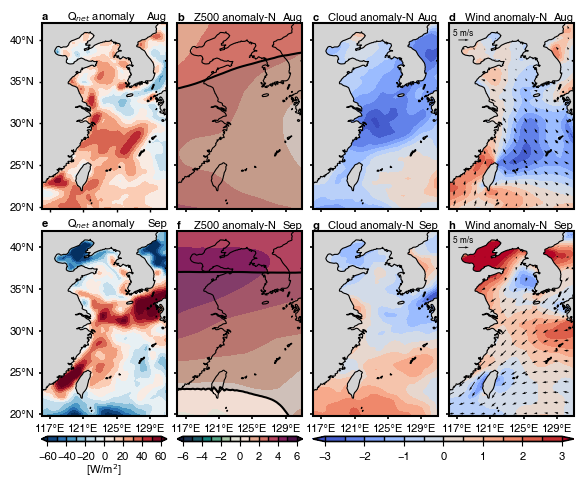

In [18]:
fig = plt.figure(figsize=(7, 5.1))
fig.subplots_adjust(wspace=0.0,hspace=0.12)
gs = GridSpec(2, 4 , figure=fig)

ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs = ax.contourf(da.longitude,da.latitude,((sw_8+lw_8+lhf_8+shf_8)[-1]-np.mean((sw_8+lw_8+lhf_8+shf_8)[10:40],0)),
                    levels= np.linspace(-60,60,13),cmap='RdBu_r',extend='both')
gl =ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl.left_labels = True
# gl.bottom_labels = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}
ax.set_xticks([117, 121, 125, 129])
ax.set_xticklabels([' ',' ',' ',' '])
ax.set_yticks([20, 25, 30, 35, 40])
ax.set_yticklabels([' ',' ',' ',' ',' '])
gl.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax.tick_params(axis='both', length=2, width=1)

ax0 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax0.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax0.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax0.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs0 = ax0.contourf(da.longitude,da.latitude,(Phigh_8[-1,2]-np.mean(Phigh_8[10:40,2],0))/np.std(Phigh_8[10:40,2],0),
                    levels= np.linspace(-6,6,13),cmap=cmaps.cmocean_curl,extend='both')
ax0.contourf(da.longitude,da.latitude,Phigh_8[-1,2],levels= [5880,6000],colors='grey',alpha=0.3, transform=ccrs.PlateCarree())
ax0.contour(da.longitude,da.latitude,Phigh_8[-1,2],levels= [5880],colors='k',linewidths=1.5,zorder=1)
gl0 =ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl0.bottom_labels = True
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
gl0.xlabel_style = {'size': 8}
gl0.ylabel_style = {'size': 8}
ax0.set_xticks([117, 121, 125, 129])
ax0.set_xticklabels([' ',' ',' ',' '])
ax0.set_yticks([20, 25, 30, 35, 40])
ax0.set_yticklabels([' ',' ',' ',' ',' '])
gl0.xlocator = ticker.FixedLocator([115, 120,125, 130])
gl0.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax0.tick_params(axis='both', length=2, width=1.2)

ax1 = fig.add_subplot(gs[0, 2], projection=ccrs.PlateCarree())
ax1.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax1.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs1 = ax1.contourf(da.longitude,da.latitude,(cloud_8[-1]-np.mean(cloud_8[10:40],0))/np.std(cloud_8[10:40],0),
                    levels= np.linspace(-3,3,13),cmap='coolwarm',extend='both')
gl1 =ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'size': 8}
gl1.ylabel_style = {'size': 8}
ax1.set_xticks([117, 121, 125, 129])
ax1.set_xticklabels([' ',' ',' ',' '])
ax1.set_yticks([20, 25, 30, 35, 40])
ax1.set_yticklabels([' ',' ',' ',' ',' '])
gl1.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl1.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax1.tick_params(axis='both', length=2, width=1.2)

ax2 = fig.add_subplot(gs[0, 3], projection=ccrs.PlateCarree())
ax2.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax2.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs2 = ax2.contourf(da.longitude,da.latitude,(((u10_8**2+v10_8**2)**.5)[-1]-np.mean(((u10_8**2+v10_8**2)**.5)[10:40],0))/np.std(((u10_8**2+v10_8**2)**.5)[10:40],0),
                    levels= np.linspace(-3,3,13),cmap='coolwarm',extend='both')
mask_uv = np.full_like(ocn_T_8[0],1)
mask_uv[np.isnan(ocn_T_8[0])] = np.nan
mask_uv[80:88,199:203] = np.nan
q = ax2.quiver(da.longitude[::5],da.latitude[::5],
        np.mean((u10_8*mask_uv)[10:40,::5,::5],0),np.mean((v10_8*mask_uv)[10:40,::5,::5],0),scale=60,width=0.006,zorder=4)
ax2.quiverkey(q, X = 0.12, Y = 0.91, U=5, label = '5 m/s', labelpos='N',labelsep=0.03,fontproperties={'size':6})
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([117, 121, 125, 129])
ax2.set_xticklabels([' ',' ',' ',' '])
ax2.set_yticks([20, 25, 30, 35, 40])
ax2.set_yticklabels([' ',' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl2.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax2.tick_params(axis='both', length=2, width=1.2)

ax4 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
ax4.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax4.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax4.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs4 = ax4.contourf(da.longitude,da.latitude,((sw_9+lw_9+lhf_9+shf_9)[-1]-np.mean((sw_9+lw_9+lhf_9+shf_9)[10:40],0)),
                    levels= np.linspace(-60,60,13),cmap='RdBu_r',extend='both')
gl4 =ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl4.left_labels = True
gl4.bottom_labels = True
gl4.xformatter = LONGITUDE_FORMATTER
gl4.yformatter = LATITUDE_FORMATTER
gl4.xlabel_style = {'size': 8}
gl4.ylabel_style = {'size': 8}
ax4.set_xticks([117, 121, 125, 129])
ax4.set_xticklabels([' ',' ',' ',' '])
ax4.set_yticks([20, 25, 30, 35, 40])
ax4.set_yticklabels([' ',' ',' ',' ',' '])
gl4.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl4.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax4.tick_params(axis='both', length=2, width=1.2)

ax5 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
ax5.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax5.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax5.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cs5 = ax5.contourf(da.longitude,da.latitude,(Phigh_9[-1,2]-np.mean(Phigh_9[10:40,2],0))/np.std(Phigh_9[10:40,2],0),
                    levels= np.linspace(-6,6,13),cmap=cmaps.cmocean_curl,extend='both')
ax5.contourf(da.longitude,da.latitude,Phigh_9[-1,2],levels= [5880,6000],colors='grey',alpha=0.3, transform=ccrs.PlateCarree())
ax5.contour(da.longitude,da.latitude,Phigh_9[-1,2],levels= [5880],colors='k',linewidths=1.5,zorder=1)
gl5 =ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl5.bottom_labels = True
gl5.xformatter = LONGITUDE_FORMATTER
gl5.yformatter = LATITUDE_FORMATTER
gl5.xlabel_style = {'size': 8}
gl5.ylabel_style = {'size': 8}
ax5.set_xticks([117, 121, 125, 129])
ax5.set_xticklabels([' ',' ',' ',' '])
ax5.set_yticks([20, 25, 30, 35, 40])
ax5.set_yticklabels([' ',' ',' ',' ',' '])
gl5.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl5.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax5.tick_params(axis='both', length=2, width=1.2)

ax6 = fig.add_subplot(gs[1, 2], projection=ccrs.PlateCarree())
ax6.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax6.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax6.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=4)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs6 = ax6.contourf(da.longitude,da.latitude,(cloud_9[-1]-np.mean(cloud_9[10:40],0))/np.std(cloud_9[10:40],0),
                    levels= np.linspace(-3,3,13),cmap='coolwarm',extend='both')
gl6 =ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl6.bottom_labels = True
gl6.xformatter = LONGITUDE_FORMATTER
gl6.yformatter = LATITUDE_FORMATTER
gl6.xlabel_style = {'size': 8}
gl6.ylabel_style = {'size': 8}
ax6.set_xticks([117, 121, 125, 129])
ax6.set_xticklabels([' ',' ',' ',' '])
ax6.set_yticks([20, 25, 30, 35, 40])
ax6.set_yticklabels([' ',' ',' ',' ',' '])
gl6.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl6.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax6.tick_params(axis='both', length=2, width=1.2)

ax7 = fig.add_subplot(gs[1, 3], projection=ccrs.PlateCarree())
ax7.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax7.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
ax7.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=0.8,zorder=2)
cmap = ListedColormap(['#FF8195','white', '#6CB5CB'])
cs7 = ax7.contourf(da.longitude,da.latitude,(((u10_9**2+v10_9**2)**.5)[-1]-np.mean(((u10_9**2+v10_9**2)**.5)[10:40],0))/np.std(((u10_9**2+v10_9**2)**.5)[10:40],0),
                    levels= np.linspace(-3,3,13),cmap='coolwarm',extend='both')
q = ax7.quiver(da.longitude[::5],da.latitude[::5],
        np.mean((u10_9*mask_uv)[10:40,::5,::5],0),np.mean((v10_9*mask_uv)[10:40,::5,::5],0),scale=60,width=0.006,zorder=4)
ax7.quiverkey(q, X = 0.12, Y = 0.91, U=5, label = '5 m/s', labelpos='N',labelsep=0.03, fontproperties={'size':6})
gl7 =ax7.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl7.bottom_labels = True
gl7.xformatter = LONGITUDE_FORMATTER
gl7.yformatter = LATITUDE_FORMATTER
gl7.xlabel_style = {'size': 8}
gl7.ylabel_style = {'size': 8}
ax7.set_xticks([117, 121, 125, 129])
ax7.set_xticklabels([' ',' ',' ',' '])
ax7.set_yticks([20, 25, 30, 35, 40])
ax7.set_yticklabels([' ',' ',' ',' ',' '])
gl7.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl7.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax7.tick_params(axis='both', length=2, width=1.2)

cax = add_bottom_cax_big(ax4,ax4, pad=0.04, width=0.01)
cb =  fig.colorbar(cs4,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-60,-40,-20,0,20,40,60])
cb.set_ticklabels(['−60','−40','−20','0','20','40','60'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('[W/m$^2$]',fontsize=8,labelpad=0)

cax = add_bottom_cax_big(ax5,ax5, pad=0.04, width=0.01)
cb =  fig.colorbar(cs5,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-6,-4,-2,0,2,4,6])
cb.set_ticklabels(['−6','−4','−2','0','2','4','6'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)

cax = add_bottom_cax_big(ax6,ax7, pad=0.04, width=0.01)
cb =  fig.colorbar(cs6,cax=cax,orientation='horizontal',drawedges=True)
cb.set_ticks([-3,-2,-1,0,1,2,3])
cb.set_ticklabels(['−3','−2','−1','0','1','2','3'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)

ax.spines['geo'].set_linewidth(1.5)
ax0.spines['geo'].set_linewidth(1.5)
ax1.spines['geo'].set_linewidth(1.5)
ax2.spines['geo'].set_linewidth(1.5)

ax4.spines['geo'].set_linewidth(1.5)
ax5.spines['geo'].set_linewidth(1.5)
ax6.spines['geo'].set_linewidth(1.5)
ax7.spines['geo'].set_linewidth(1.5)


ax.set_title('Q$_{net}$ anomaly   ',fontsize=8,pad=2)
ax0.set_title('Z500 anomaly-N   ',fontsize=8,pad=2)
ax1.set_title('Cloud anomaly-N   ',fontsize=8,pad=2)
ax2.set_title('Wind anomaly-N   ',fontsize=8,pad=2)

ax4.set_title('Q$_{net}$ anomaly   ',fontsize=8,pad=2)
ax5.set_title('Z500 anomaly-N   ',fontsize=8,pad=2)
ax6.set_title('Cloud anomaly-N   ',fontsize=8,pad=2)
ax7.set_title('Wind anomaly-N   ',fontsize=8,pad=2)

ax.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax0.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)
ax1.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('d',fontsize=8,loc='left',fontweight='bold',pad=2)

ax4.set_title('e',fontsize=8,loc='left',fontweight='bold',pad=2)
ax5.set_title('f',fontsize=8,loc='left',fontweight='bold',pad=2)
ax6.set_title('g',fontsize=8,loc='left',fontweight='bold',pad=2)
ax7.set_title('h',fontsize=8,loc='left',fontweight='bold',pad=2)

ax.set_title('Aug',fontsize=8,loc='right',pad=2)
ax0.set_title('Aug',fontsize=8,loc='right',pad=2)
ax1.set_title('Aug',fontsize=8,loc='right',pad=2)
ax2.set_title('Aug',fontsize=8,loc='right',pad=2)

ax4.set_title('Sep',fontsize=8,loc='right',pad=2)
ax5.set_title('Sep',fontsize=8,loc='right',pad=2)
ax6.set_title('Sep',fontsize=8,loc='right',pad=2)
ax7.set_title('Sep',fontsize=8,loc='right',pad=2)

fig.savefig('./fig/Fig2.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

In [42]:
t = xr.open_dataset('ORAS5/T.nc')['votemper'][:,0,:,:].interp(lon=sst_ES_oisst.lon,lat=sst_ES_oisst.lat).squeeze()
sst_era5 = xr.open_dataset('./ERA5/sst.nc')['sst'].interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data).squeeze()
qnet = xr.open_dataset('ORAS5/qnet.nc')['sohefldo'].interp(lon=sst_ES_oisst.lon,lat=sst_ES_oisst.lat).squeeze()
qnet_era5 = (xr.open_dataset('ERA5/rain_flux.nc')['msshf'].interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data).data + 
            xr.open_dataset('ERA5/rain_flux.nc')['mslhf'].interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data).data + 
            xr.open_dataset('ERA5/rain_flux.nc')['msnswrf'].interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data).data + 
            xr.open_dataset('ERA5/rain_flux.nc')['msnlwrf'].interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data).data)
qnet_oras5 = sel_year(qnet,8,9)
sst_oras5 = sel_year(t,8,9)

sst_high_oras5 = weight_mean(t*mask_hightemp,dx,dy)
base_high_oras5 = np.mean(np.reshape(sst_high_oras5[120:480],(30,12)),0)
std_high_oras5 = np.std(np.reshape(sst_high_oras5[120:480],(30,12)),0)

sst_high_era5 = weight_mean(sst_era5*mask_hightemp,dx,dy)
base_high_era5 = np.mean(np.reshape(sst_high_era5[120:480],(30,12)),0)
std_high_era5 = np.std(np.reshape(sst_high_era5[120:480],(30,12)),0)

hycom = xr.open_dataset('HYCOM//HYCOM_3z.nc')['pot_temp'][:,0].interp(Longitude=sst_ES_oisst.lon.data,Latitude=sst_ES_oisst.lat.data).squeeze()
sst_hycom = (sel_year(hycom,8,9))[:-10]
sst_high_hycom = weight_mean(hycom*mask_hightemp,dx,dy)
base_high_hycom = np.mean(np.reshape(sst_high_hycom[12:372],(30,12)),0)
std_high_hycom = np.std(np.reshape(sst_high_hycom[12:372],(30,12)),0)

In [253]:
# qnet_high_oras5 = weight_mean(qnet*mask_hightemp,dx,dy)
# qnet_high_hycom = weight_mean(qnet_hycom*mask_hightemp,dx,dy)
# qnet_high_era5 = weight_mean(qnet_era5*mask_hightemp,dx,dy)

In [266]:
def sel_year_hycom(data,m1,m2):
    res = np.zeros((35,np.shape(data)[1],np.shape(data)[2]))
    for i in range(35):
        res[i] = np.mean(data[12*i+m1-1:12*i+m2],0)
    return res

In [43]:
da = xr.open_dataset('./GLORYS/GLORYS_clim_dailymean.nc').interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
t_glo_m = da.sel(time=~((da.time.dt.month == 2) & (da.time.dt.day == 29)))['thetao'].data
da = xr.open_dataset('./GLORYS/GLORYS12V1.nc').interp(longitude=sst_ES_oisst.lon.data,latitude=sst_ES_oisst.lat.data)
t_glo = da.sel(time=~((da.time.dt.month == 2) & (da.time.dt.day == 29)))['thetao'].data
t_glo_p = t_glo - t_glo_m
sst_high_glo = weight_mean(t_glo_p[:,0,:,:]*mask_hightemp,dx,dy)

In [24]:
# MEERA2 = xr.open_dataset('MERRA2/MERRA2_ocn.nc').interp(lon=sst_ES_oisst.lon,lat=sst_ES_oisst.lat).squeeze()
# qnet_merra = - MEERA2.EFLUXWTR.data - MEERA2.HFLUXWTR.data + MEERA2.LWGNTWTR.data + MEERA2.SWGNTWTR.data

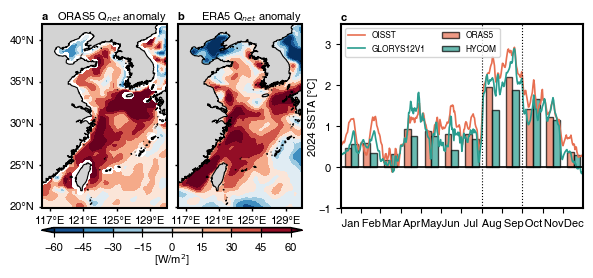

In [103]:
fig = plt.figure(figsize=(7, 2.4))
fig.subplots_adjust(wspace=0.065)
gs = GridSpec(1, 4 , figure=fig,width_ratios=[1,1,0.16,1.9])

ax0 = fig.add_subplot(gs[0, 3])
ax0.bar(date_month_oisst[-24:-12] - pd.Timedelta(days=19),sst_high_oras5[-12:]-base_high_oras5,width=10,edgecolor='k',facecolor='#E76F51',lw=1,alpha=0.7,label='ORAS5')
ax0.bar(date_month_oisst[-24:-12] - pd.Timedelta(days=9),sst_high_hycom[-12:]-base_high_hycom,width=10,edgecolor='k',facecolor='#2A9D8F',lw=1,alpha=0.7,label='HYCOM')
ax0.plot(date,sst_high[365*42:]-base_high,'#E76F51',lw=1.2,label='OISST')
ax0.plot(date,sst_high_glo,'#2A9D8F',lw=1.2,label='GLORYS12V1')
ax0.plot(date,np.zeros(365),'k',lw=1.2)
ax0.plot([date[212],date[212]],[-5,5],'k',lw=0.8,ls=':')
ax0.plot([date[273],date[273]],[-5,5],'k',lw=0.8,ls=':')
ax0.set_xlim([date[0],date[-1]])
ax0.set_ylim([-1,3.5])
ax0.set_xticks(date[[0,31,59,90,120,151,181,212,243,273,304,334]],['      Jan','      Feb','       Mar','       Apr','       May','      Jun',
                                                                   '      Jul','      Aug','       Sep','       Oct','       Nov','       Dec'],fontsize=8)
ax0.set_yticks([-1,0,1,2,3],['−1','0','1','2','3'],fontsize=8)
# ax0.set_xlabel('Month',fontsize=8)
ax0.set_ylabel('2024 SSTA [°C]',fontsize=8,labelpad=0)
ax0.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=2,fontsize=6)
ax0.spines[['top','bottom','left','right']].set_linewidth(1.5)
# inset_ax = inset_axes(ax0, width="12.5%", height="22%", loc="upper right")
# inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_land[70:,45:],colors='lightgray')
# inset_ax.contourf(Lon[70:,45:],Lat[70:,45:],mask_hightemp[70:,45:],colors='k')
# inset_ax.set_xticks([])
# inset_ax.set_yticks([])

# ax1 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree())
# ax1.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax1.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
# ax1.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=1,zorder=4)
# cs1 = ax1.contourf(Lon,Lat,(sst_oras5[-1]-np.mean(sst_oras5[10:40],0))/np.std(sst_oras5[10:40],0),
#                     levels= np.linspace(-6,6,13),cmap=cmaps.ncl_default,extend='both')
# gl1 =ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl1.left_labels = True
# gl1.bottom_labels = True
# gl1.xformatter = LONGITUDE_FORMATTER
# gl1.yformatter = LATITUDE_FORMATTER
# gl1.xlabel_style = {'size': 12}
# gl1.ylabel_style = {'size': 12}
# ax1.set_xticks([117, 121, 125, 129])
# ax1.set_xticklabels([' ',' ',' ',' '])
# ax1.set_yticks([20, 25, 30, 35, 40])
# ax1.set_yticklabels([' ',' ',' ',' ',' '])
# gl1.xlocator = ticker.FixedLocator([115, 120,125, 130])
# gl1.ylocator = ticker.FixedLocator([20,25, 30,35,40])
# ax1.tick_params(axis='both', length=2, width=1.2)

# ax11 = fig.add_subplot(gs[1, 1], projection=ccrs.PlateCarree())
# ax11.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
# ax11.add_feature(cfeature.LAND.with_scale('50m'),facecolor='lightgray',zorder=2)
# ax11.add_feature(cfeature.COASTLINE.with_scale('50m'),lw=1,zorder=4)
# cs11 = ax11.contourf(Lon,Lat,(sst_hycom[-1]-np.mean(sst_hycom[1:31],0))/np.std(sst_hycom[1:31],0),
#                     levels= np.linspace(-3,3,13),cmap=cmaps.ncl_default,extend='both')
# gl11 =ax11.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# # gl11.left_labels = True
# gl11.bottom_labels = True
# gl11.xformatter = LONGITUDE_FORMATTER
# gl11.yformatter = LATITUDE_FORMATTER
# gl11.xlabel_style = {'size': 12}
# gl11.ylabel_style = {'size': 12}
# ax11.set_xticks([117, 121, 125, 129])
# ax11.set_xticklabels([' ',' ',' ',' '])
# ax11.set_yticks([20, 25, 30, 35, 40])
# ax11.set_yticklabels([' ',' ',' ',' ',' '])
# gl11.xlocator = ticker.FixedLocator([115, 120,125, 130])
# gl11.ylocator = ticker.FixedLocator([20,25, 30,35,40])
# ax11.tick_params(axis='both', length=2, width=1.2)

ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax2.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax2.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder=2)
ax2.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=0.8,zorder=4)
cs2 = ax2.contourf(Lon,Lat,(qnet_oras5[-1]-np.mean(qnet_oras5[10:40],0)),
                    levels= np.linspace(-60,60,9),cmap='RdBu_r',extend='both')
gl2 =ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
gl2.left_labels = True
gl2.bottom_labels = True
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'size': 8}
gl2.ylabel_style = {'size': 8}
ax2.set_xticks([117, 121, 125, 129])
ax2.set_xticklabels([' ',' ',' ',' '])
ax2.set_yticks([20, 25, 30, 35, 40])
ax2.set_yticklabels([' ',' ',' ',' ',' '])
gl2.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl2.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax2.tick_params(axis='both', length=2, width=1)

ax3 = fig.add_subplot(gs[0, 1], projection=ccrs.PlateCarree())
ax3.set_extent([116,131,19.8,42], crs=ccrs.PlateCarree())
ax3.add_feature(cfeature.LAND.with_scale('10m'),facecolor='lightgray',zorder=2)
ax3.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=0.8,zorder=4)
cs3 = ax3.contourf(da.longitude,da.latitude,((sw_8+lw_8+lhf_8+shf_8+sw_9+lw_9+lhf_9+shf_9)[-1]
                                            -np.mean((sw_8+lw_8+lhf_8+shf_8+sw_9+lw_9+lhf_9+shf_9)[10:40],0)),
                    levels= np.linspace(-60,60,9),cmap='RdBu_r',extend='both')
gl3 =ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.0, color='k')
# gl3.left_labels = True
gl3.bottom_labels = True
gl3.xformatter = LONGITUDE_FORMATTER
gl3.yformatter = LATITUDE_FORMATTER
gl3.xlabel_style = {'size': 8}
gl3.ylabel_style = {'size': 8}
ax3.set_xticks([117, 121, 125, 129])
ax3.set_xticklabels([' ',' ',' ',' '])
ax3.set_yticks([20, 25, 30, 35, 40])
ax3.set_yticklabels([' ',' ',' ',' ',' '])
gl3.xlocator = ticker.FixedLocator([117, 121, 125, 129])
gl3.ylocator = ticker.FixedLocator([20,25, 30,35,40])
ax3.tick_params(axis='both', length=2, width=1)

# cax = add_bottom_cax_big(ax1,ax1, pad=0.03, width=0.01)
# cb =  fig.colorbar(cs1,cax=cax,drawedges=True,orientation='horizontal')
# cb.set_ticks([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6])
# cb.set_ticklabels([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6],fontsize=13)
# cb.outline.set_edgecolor('black')
# cb.outline.set_linewidth(1.8)
# cb.dividers.set_linewidth(1)
# cb.set_label('[°C]',fontsize=14)

# cax = add_bottom_cax_big(ax11,ax11, pad=0.03, width=0.01)
# cb =  fig.colorbar(cs11,cax=cax,drawedges=True,orientation='horizontal')
# cb.set_ticks([-3,-2,-1,0,1,2,3])
# cb.set_ticklabels([-3,-2,-1,0,1,2,3],fontsize=13)
# cb.outline.set_edgecolor('black')
# cb.outline.set_linewidth(1.8)
# cb.dividers.set_linewidth(1)
# cb.set_label('[°C]',fontsize=14)

cax = add_bottom_cax_big(ax2,ax3, pad=0.08, width=0.02)
cb =  fig.colorbar(cs3,cax=cax,drawedges=True,orientation='horizontal')
cb.set_ticks([-60,-45,-30,-15,0,15,30,45,60])
cb.set_ticklabels(['−60','−45','−30','−15','0','15','30','45','60'],fontsize=8)
cb.outline.set_edgecolor('black')
cb.outline.set_linewidth(1.2)
cb.dividers.set_linewidth(1)
cb.set_label('[W/m$^2$]',fontsize=8,labelpad=0)

ax2.spines['geo'].set_linewidth(1.5)
ax3.spines['geo'].set_linewidth(1.5)

ax2.set_title('ORAS5 Q$_{net}$ anomaly',fontsize=8,loc='right',pad=2)
ax3.set_title('ERA5 Q$_{net}$ anomaly',fontsize=8,loc='right',pad=2)

ax0.set_title('c',fontsize=8,loc='left',fontweight='bold',pad=2)
ax2.set_title('a',fontsize=8,loc='left',fontweight='bold',pad=2)
ax3.set_title('b',fontsize=8,loc='left',fontweight='bold',pad=2)

fig.savefig('./fig/FigS9.' + fig_format, format=fig_format, dpi = 300, bbox_inches='tight')

## Time Scale

In [ ]:
t_long_o_high,t_multidecad_o_high,t_intan_o_high,t_highf_o_high = tscale_filter(weight_mean(sst_month_oisst*mask_hightemp,dx,dy))
t_long_high,t_multidecad_high,t_intan_high,t_highf_high = tscale_filter(weight_mean(t_prime*mask_hightemp,dx,dy))
dt_long_high,dt_multidecad_high,dt_intan_high,dt_highf_high = tscale_filter(weight_mean(dt_prime*mask_hightemp,dx,dy))
q_long_high,q_multidecad_high,q_intan_high,q_highf_high = tscale_filter(weight_mean((flux_Q)*mask_hightemp,dx,dy))
o_long_high,o_multidecad_high,o_intan_high,o_highf_high = tscale_filter(weight_mean((flux_H+adv_pp+adv_bp+adv_pb+en_pb+en_bp+en_pp)*mask_hightemp,dx,dy))

In [ ]:
t_long_o_YS,t_multidecad_o_YS,t_intan_o_YS,t_highf_o_YS = tscale_filter(weight_mean(sst_month_oisst*mask_YS,dx,dy))
t_long_YS,t_multidecad_YS,t_intan_YS,t_highf_YS = tscale_filter(weight_mean(t_prime*mask_YS,dx,dy))
dt_long_YS,dt_multidecad_YS,dt_intan_YS,dt_highf_YS = tscale_filter(weight_mean(dt_prime*mask_YS,dx,dy))
q_long_YS,q_multidecad_YS,q_intan_YS,q_highf_YS = tscale_filter(weight_mean((flux_Q)*mask_YS,dx,dy))
o_long_YS,o_multidecad_YS,o_intan_YS,o_highf_YS = tscale_filter(weight_mean((flux_H+adv_pp+adv_bp+adv_pb+en_pb+en_bp+en_pp)*mask_YS,dx,dy))

In [ ]:
t_long_o_ECS,t_multidecad_o_ECS,t_intan_o_ECS,t_highf_o_ECS = tscale_filter(weight_mean(sst_month_oisst*mask_ECS,dx,dy))
t_long_ECS,t_multidecad_ECS,t_intan_ECS,t_highf_ECS = tscale_filter(weight_mean(t_prime*mask_ECS,dx,dy))
dt_long_ECS,dt_multidecad_ECS,dt_intan_ECS,dt_highf_ECS = tscale_filter(weight_mean(dt_prime*mask_ECS,dx,dy))
q_long_ECS,q_multidecad_ECS,q_intan_ECS,q_highf_ECS = tscale_filter(weight_mean((flux_Q)*mask_ECS,dx,dy))
o_long_ECS,o_multidecad_ECS,o_intan_ECS,o_highf_ECS = tscale_filter(weight_mean((flux_H+adv_pp+adv_bp+adv_pb+en_pb+en_bp+en_pp)*mask_ECS,dx,dy))

In [ ]:
t_long_o_SCS,t_multidecad_o_SCS,t_intan_o_SCS,t_highf_o_SCS = tscale_filter(weight_mean(sst_month_oisst*mask_SCS,dx,dy))
t_long_SCS,t_multidecad_SCS,t_intan_SCS,t_highf_SCS = tscale_filter(weight_mean(t_prime*mask_SCS,dx,dy))
dt_long_SCS,dt_multidecad_SCS,dt_intan_SCS,dt_highf_SCS = tscale_filter(weight_mean(dt_prime*mask_SCS,dx,dy))
q_long_SCS,q_multidecad_SCS,q_intan_SCS,q_highf_SCS = tscale_filter(weight_mean((flux_Q)*mask_SCS,dx,dy))
o_long_SCS,o_multidecad_SCS,o_intan_SCS,o_highf_SCS = tscale_filter(weight_mean((flux_H+adv_pp+adv_bp+adv_pb+en_pb+en_bp+en_pp)*mask_SCS,dx,dy))

In [ ]:
nino34 = gaussian_filter(np.reshape(np.array(pd.read_csv('Clim_index/NINO34.csv',header=None,encoding='UTF-8'))[:,1:],-1),6/1.414)
pdo = gaussian_filter(np.reshape(np.array(pd.read_csv('Clim_index/PDO.csv',header=None,encoding='UTF-8'))[:,1:],-1),48/1.414)

## TOPO

In [173]:
# fpath = '/2024data2/yangsl/Yangsl/etopo5.nc'  # 你的海平面温度数据文件路径
# topo = xr.open_dataset(fpath).sel(lon=slice(1230,1600),lat=slice(1050,1600))
# etopo = np.array(topo.topo,dtype='float')
# etopo[etopo>=0] = np.nan

Text(0.5, 1.0, 'Topography of the study area [m]')

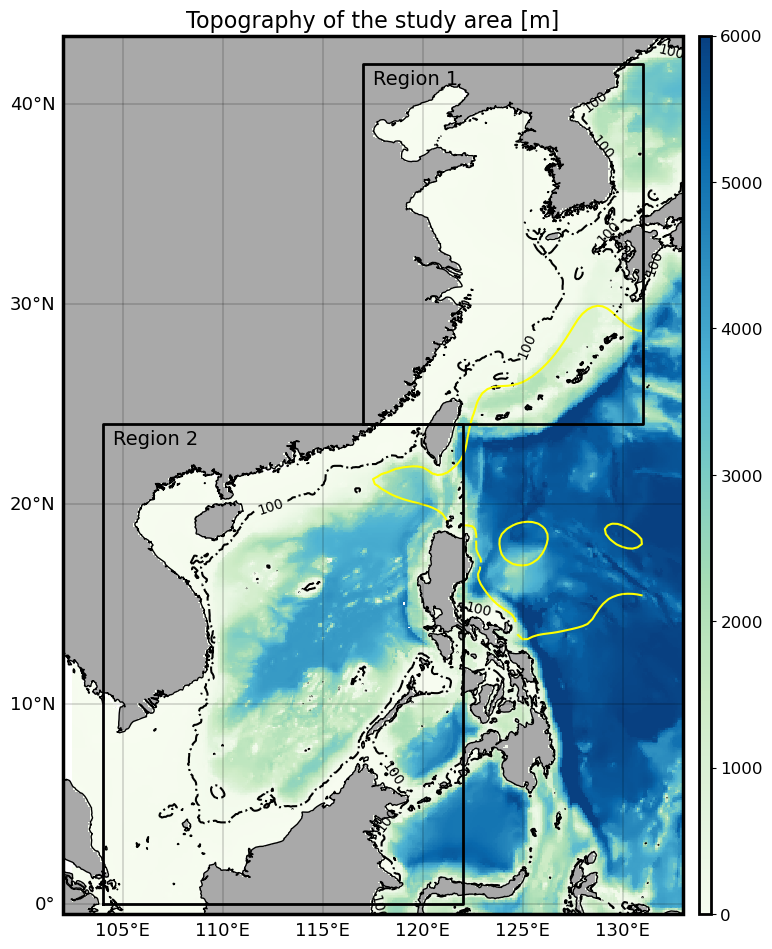

In [ ]:
# Plot
fig = plt.figure(figsize=(8, 12))
# fig.subplots_adjust(hspace=0.1,wspace=0.02)
gs = GridSpec(1, 1, figure=fig)
ax0 = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree())
ax0.add_feature(cfeature.LAND.with_scale('10m'),facecolor='darkgrey',zorder=1)
ax0.add_feature(cfeature.COASTLINE.with_scale('10m'),lw=1,zorder=4)
ax0.set_extent([102,133,-0.5,42.5])
cs = ax0.pcolormesh(topo.topo_lon,topo.topo_lat,-etopo,cmap='GnBu',vmin=0,vmax=6000, transform=ccrs.PlateCarree())
contour_lines = ax0.contour(topo.topo_lon,topo.topo_lat,-etopo, levels=[100],
    colors='black', linestyles='-.', transform=ccrs.PlateCarree())
ax0.contour(
    ssh.lon, ssh.lat, ssh, levels=[1],
    colors='yellow', transform=ccrs.PlateCarree())

ax0.clabel(contour_lines, inline=True, fontsize=10, fmt='%1d')
ax0.plot([104,122,122,104,104],[0,0,24,24,0],c='k',lw=2, transform=ccrs.PlateCarree())
ax0.plot([117,131,131,117,117],[24,24,42,42,24],c='k',lw=2, transform=ccrs.PlateCarree())
gl0 =ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=0.2, color='k')
gl0.left_labels = True
gl0.bottom_labels = True
gl0.xformatter = LONGITUDE_FORMATTER
gl0.yformatter = LATITUDE_FORMATTER
gl0.xlabel_style = {'size': 13}
gl0.ylabel_style = {'size': 13}
ax0.spines['geo'].set_linewidth(2.5)
cax = add_right_cax_big(ax0,ax0, pad=0.02, width=0.015)
cb =  fig.colorbar(cs,cax=cax)
cb.outline.set_linewidth(2)
cb.set_ticks([0,1000,2000,3000,4000,5000,6000])
cb.set_ticklabels([0,1000,2000,3000,4000,5000,6000],fontsize=12)
ax0.text(117.5,41,'Region 1',c='k',fontsize=14)
ax0.text(104.5,23,'Region 2',c='k',fontsize=14)
ax0.set_title('Topography of the study area [m]',fontsize=16)